<a href="https://colab.research.google.com/github/Tobi-KL/SOC_Profile_Generation/blob/main/Run_SOC_Profile_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import packages and change directory

In [2]:
import sys
import os

# Input path directory
path_directory = "/content/drive/MyDrive/Tobias_MA/Abgabe/SOC_Profile_Generation"

sys.path.insert(0, path_directory)
os.chdir(path_directory)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import csv
import os.path

from classes.household import Household
from functions.rank_households import rank_households
from functions.rank_households_all import rank_households_all
from functions.create_soc_profiles import create_soc_profiles
#from functions.aggregated_profiles import aggregated_profiles
from functions.aggregated_profiles_day import aggregated_profiles_day
from functions.aggregated_profiles_week import aggregated_profiles_week
from functions.aggregated_profiles_strategies import aggregated_profiles_strategies
from functions.aggregated_profiles_lvp import aggregated_profiles_lvp

### Load data

In [4]:
### Mobility Data

mobility_data_pkl_path =  path_directory + '/inputs/data_mop_priority.pkl'


### TANK Data (MOP):
# needed for car segment (in column [174])
mob_car_info_csv_path = path_directory + '/inputs/TANK18.csv'

### Electric Car database for car substitution
# [:,3]: Battery capacity [kWh]
# [:,4]: WLTP-consumption [kWh / 100km]
# [:,5]: Car Charging power [kW]
el_cars_csv_path = path_directory + '/inputs/Elektroauto_Datenbank.csv'

### Temperature [°C] in time period (same timesteps)
weather_csv_path = path_directory + '/inputs/Temperaturen_Deutschland_2017.csv'

### Timesteps
# Input timestep length and number of timesteps
ts_length = 10
no_of_ts = 1008
#no_of_ts = int (states_mop.shape[1])   # needs to process data first

In [5]:
### Data Processing

# pkl file
with open(mobility_data_pkl_path, 'rb') as input:
        [states_mop,speed_mop,meta_mop,meta_header_mop] = pickle.load(input)
# observe only year 2017
meta_mop_data = meta_mop[-3820:-1,]
states_mop_data = states_mop[-3820:-1,]
speed_mop_data = speed_mop[-3820:-1,]

# csv files
mob_car_info_csv = np.genfromtxt (mob_car_info_csv_path, 
                                  delimiter=";", 
                                  encoding = "ISO-8859-1")

el_cars_csv = np.genfromtxt (el_cars_csv_path, 
                             delimiter=";", 
                             encoding = "ISO-8859-1")

weather_csv = np.genfromtxt (weather_csv_path, 
                             delimiter=";", 
                             encoding = "ISO-8859-1")

# sort data by weekdays
for i in range(len(states_mop_data)):
    dates = meta_mop_data[i,32:39]
    dates = pd.to_timedelta(dates, unit='D') + pd.Timestamp('1960-1-1')
    weekdays = dates.strftime("%A")
    if (weekdays[0] == "Sunday"):
        part_1 = states_mop_data[i,144:]
        part_2 = states_mop_data[i,0:144]
        states_mop_data[i] = np.concatenate((part_1, part_2))
        part_1_speeds = speed_mop_data[i,144:]
        part_2_speeds = speed_mop_data[i,0:144]
        speed_mop_data[i] = np.concatenate((part_1_speeds, part_2_speeds)) 
    elif (weekdays[0] == "Saturday"):
        part_1 = states_mop_data[i,288:]
        part_2 = states_mop_data[i,0:288]
        states_mop_data[i] = np.concatenate((part_1, part_2))
        part_1_speeds = speed_mop_data[i,288:]
        part_2_speeds = speed_mop_data[i,0:288]
        speed_mop_data[i] = np.concatenate((part_1_speeds, part_2_speeds)) 
    elif (weekdays[0] == "Friday"):
        part_1 = states_mop_data[i,432:]
        part_2 = states_mop_data[i,0:432]
        states_mop_data[i] = np.concatenate((part_1, part_2))
        part_1_speeds = speed_mop_data[i,432:]
        part_2_speeds = speed_mop_data[i,0:432]
        speed_mop_data[i] = np.concatenate((part_1_speeds, part_2_speeds)) 
    elif (weekdays[0] == "Thursday"):
        part_1 = states_mop_data[i,576:]
        part_2 = states_mop_data[i,0:576]
        states_mop_data[i] = np.concatenate((part_1, part_2))
        part_1_speeds = speed_mop_data[i,576:]
        part_2_speeds = speed_mop_data[i,0:576]
        speed_mop_data[i] = np.concatenate((part_1_speeds, part_2_speeds)) 
    elif (weekdays[0] == "Wednesday"):
        part_1 = states_mop_data[i,720:]
        part_2 = states_mop_data[i,0:720]
        states_mop_data[i] = np.concatenate((part_1, part_2))
        part_1_speeds = speed_mop_data[i,720:]
        part_2_speeds = speed_mop_data[i,0:720]
        speed_mop_data[i] = np.concatenate((part_1_speeds, part_2_speeds)) 
    elif (weekdays[0] == "Tuesday"):
        part_1 = states_mop_data[i,864:]
        part_2 = states_mop_data[i,0:864]
        states_mop_data[i] = np.concatenate((part_1, part_2))
        part_1_speeds = speed_mop_data[i,864:]
        part_2_speeds = speed_mop_data[i,0:864]
        speed_mop_data[i] = np.concatenate((part_1_speeds, part_2_speeds))

### Rank households

In [6]:
# Rank households according to your input

# Choose the following main parameters (will be fulfilled)
input_number_of_occupants = 1
input_number_of_drivers = 1
input_number_of_cars = 1


# Choose the following five soft parameters and their weight.
# Fitting households will be sorted by weighted soft parameters.
# Sum of all weights = 1.0
# Find codes in Codeplan_SOC_Profile_Generation.md on github
input_income = 1
input_w_income = 0.2

input_population = 9
input_w_population = 0.2

input_year_of_birth = 1980
input_w_year_of_birth = 0.2

input_job = 1
input_w_job = 0.2

# [km / week]
input_distance = 1000
input_w_distance = 0.2

# How many households should be returned?
# Put "all", if all fitting households should be returned
quantity = 100

###

households = rank_households(meta_mop_data,
                             states_mop_data,
                             speed_mop_data,
                             no_of_ts, 
                             ts_length,
                             input_number_of_occupants,
                             input_number_of_drivers,
                             input_number_of_cars, 
                             input_income,
                             input_w_income,
                             input_population,
                             input_w_population,
                             input_year_of_birth,
                             input_w_year_of_birth,
                             input_job,
                             input_w_job,
                             input_distance,
                             input_w_distance,
                             quantity)
print(households)

/content/drive/MyDrive/Tobias_MA/Abgabe/SOC_Profile_Generation/functions/rank_households.py:166: RuntimeWarning: overflow encountered in long_scalars
  job_diff = job_hh - job
/content/drive/MyDrive/Tobias_MA/Abgabe/SOC_Profile_Generation/functions/rank_households.py:133: RuntimeWarning: overflow encountered in long_scalars
  income_diff = income_hh - income


Number of fitting households: 366
[4711036134, 4511021886, 8511021339, 4711030364, 4511021849, 4511021085, 4511020554, 4301011872, 4711030920, 4711030517, 4701035981, 4511020885, 4511020331, 4501024234, 4501023822, 8711032028, 8711031249, 8711031105, 8701035896, 8701035540, 8511020387, 8311015369, 4711032221, 4711032145, 4711032104, 4711031936, 4711031640, 4711031419, 4711031198, 4711030937, 4711030900, 4711030608, 4711030459, 4701036022, 4701034993, 4701034973, 4701034955, 4701034745, 4701034291, 4701034271, 4701033995, 4701033886, 4701033880, 4701032412, 4511021845, 4511021704, 4511021288, 4511021194, 4511021061, 4501026430, 4501026225, 4501026087, 4501025706, 4501025246, 4501024646, 4501024210, 4501024009, 4501023994, 4501023143, 4501022793, 4501022653, 4311011454, 4311011155, 4301015137, 4301013963, 4301013576, 4301012983, 4301011882, 4701033867, 4501024727, 4501024541, 8711032039, 8711030893, 8711030806, 8701035936, 8511021768, 8511021758, 8511021405, 8501025784, 8311010308, 83010

In [7]:
# Rank all households

# Choose the following main parameters (will be fulfilled)
input_number_of_occupants = 2
input_number_of_drivers = 2
input_number_of_cars = 2


# Choose the following five soft parameters and their weight.
# Fitting households will be sorted by weighted soft parameters.
# Sum of all weights = 1.0
# Find codes in Codeplan_SOC_Profile_Generation.md on github
input_income = 1
input_w_income = 0

input_population = 9
input_w_population = 0

input_year_of_birth = 1980
input_w_year_of_birth = 0

input_job = 1
input_w_job = 0

# [km / week]
input_distance = 100
input_w_distance = 1

# How many households should be returned?
# Put "all", if all fitting households should be returned
quantity = "all"

###

all_households = rank_households_all(meta_mop_data,
                             states_mop_data,
                             speed_mop_data,
                             no_of_ts, 
                             ts_length,
                             input_number_of_occupants,
                             input_number_of_drivers,
                             input_number_of_cars, 
                             input_income,
                             input_w_income,
                             input_population,
                             input_w_population,
                             input_year_of_birth,
                             input_w_year_of_birth,
                             input_job,
                             input_w_job,
                             input_distance,
                             input_w_distance,
                             quantity)
print(len(all_households))

1483


### SOC Profile Generation



Household: 4711036134
Car: 1
Segment: [3]

Overall energy demand, Household 4711036134 , Car 1 [kWh]: 162.18297199999998

Home energy demand max strategy, Household 4711036134 , Car 1 [kWh]: 118.52447663000032

Work energy demand max strategy, Household 4711036134 , Car 1 [kWh]: 60.28224999999994

Home energy demand min strategy, Household 4711036134 , Car 1 [kWh]: 132.10994115789526

Work energy demand min strategy, Household 4711036134 , Car 1 [kWh]: 39.72186805263156




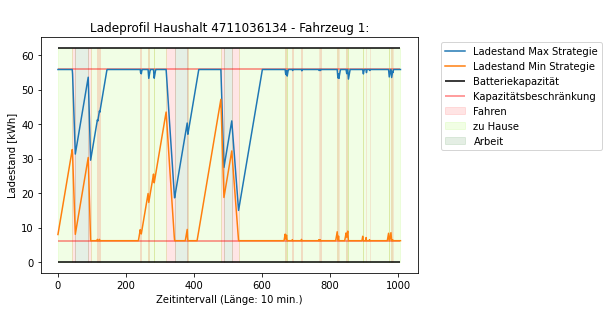





Household: 4511021886
Car: 1
Segment: [4]

Overall energy demand, Household 4511021886 , Car 1 [kWh]: 209.99785200000028

Home energy demand max strategy, Household 4511021886 , Car 1 [kWh]: 138.51957072625132

Work energy demand max strategy, Household 4511021886 , Car 1 [kWh]: 38.5128285937504

Home energy demand min strategy, Household 4511021886 , Car 1 [kWh]: 184.66213352631718

Work energy demand min strategy, Household 4511021886 , Car 1 [kWh]: 46.21050552631596




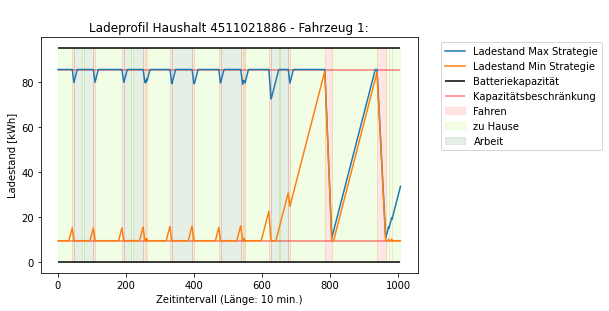





Household: 8511021339
Car: 1
Segment: 3

Overall energy demand, Household 8511021339 , Car 1 [kWh]: 162.0240812

Home energy demand max strategy, Household 8511021339 , Car 1 [kWh]: 122.01353502625042

Work energy demand max strategy, Household 8511021339 , Car 1 [kWh]: 54.29456906999992

Home energy demand min strategy, Household 8511021339 , Car 1 [kWh]: 89.93116414210543

Work energy demand min strategy, Household 8511021339 , Car 1 [kWh]: 84.22708350000012




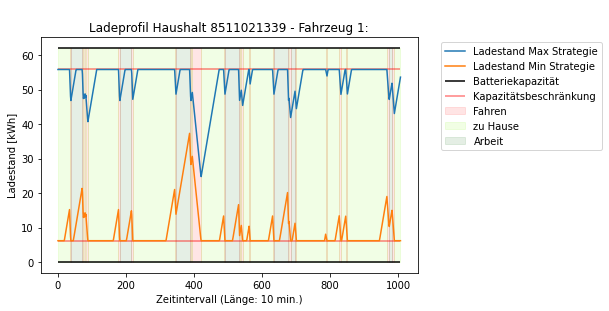





Household: 4711030364
Car: 1
Segment: [3]


Household: 4511021849
Car: 1
Segment: [2]

Overall energy demand, Household 4511021849 , Car 1 [kWh]: 183.2507462333332

Home energy demand max strategy, Household 4511021849 , Car 1 [kWh]: 148.40901310725073

Work energy demand max strategy, Household 4511021849 , Car 1 [kWh]: 13.185630255000031

Home energy demand min strategy, Household 4511021849 , Car 1 [kWh]: 166.8628158105272

Work energy demand min strategy, Household 4511021849 , Car 1 [kWh]: 33.21698265789472




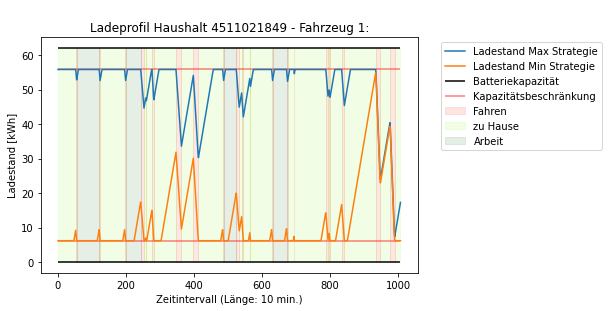





Household: 4511021085
Car: 1
Segment: 3


Household: 4511020554
Car: 1
Segment: [5]

Overall energy demand, Household 4511020554 , Car 1 [kWh]: 188.86133208333314

Home energy demand max strategy, Household 4511020554 , Car 1 [kWh]: 133.25595467187662

Work energy demand max strategy, Household 4511020554 , Car 1 [kWh]: 74.96366395000047

Home energy demand min strategy, Household 4511020554 , Car 1 [kWh]: 133.8938341447375

Work energy demand min strategy, Household 4511020554 , Car 1 [kWh]: 72.38713815789475




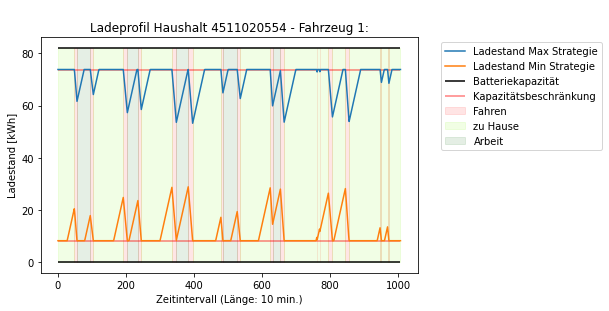





Household: 4301011872
Car: 1
Segment: 3

Overall energy demand, Household 4301011872 , Car 1 [kWh]: 172.76407706666666

Home energy demand max strategy, Household 4301011872 , Car 1 [kWh]: 106.89932112125032

Work energy demand max strategy, Household 4301011872 , Car 1 [kWh]: 83.57307384475014

Home energy demand min strategy, Household 4301011872 , Car 1 [kWh]: 130.0814974789479

Work energy demand min strategy, Household 4301011872 , Car 1 [kWh]: 60.86827191052624




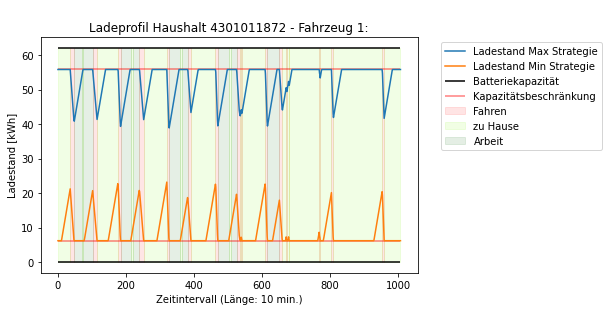





Household: 4711030920
Car: 1
Segment: 3

Overall energy demand, Household 4711030920 , Car 1 [kWh]: 84.87096783333331

Home energy demand max strategy, Household 4711030920 , Car 1 [kWh]: 49.879674521249974

Work energy demand max strategy, Household 4711030920 , Car 1 [kWh]: 43.690567514999934

Home energy demand min strategy, Household 4711030920 , Car 1 [kWh]: 52.16208642105258

Work energy demand min strategy, Household 4711030920 , Car 1 [kWh]: 41.02754249999996




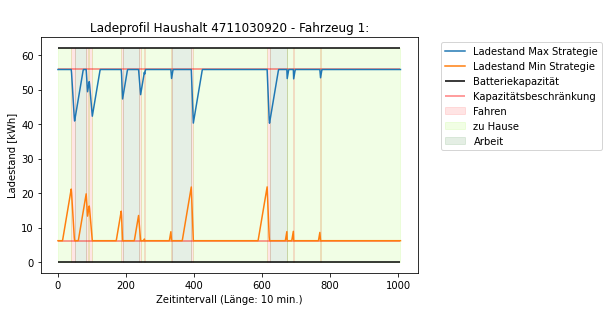





Household: 4711030517
Car: 1
Segment: [8]

Overall energy demand, Household 4711030517 , Car 1 [kWh]: 124.00016699999998

Home energy demand max strategy, Household 4711030517 , Car 1 [kWh]: 100.22879721750095

Work energy demand max strategy, Household 4711030517 , Car 1 [kWh]: 36.48138690000036

Home energy demand min strategy, Household 4711030517 , Car 1 [kWh]: 99.16312921052659

Work energy demand min strategy, Household 4711030517 , Car 1 [kWh]: 36.37754326315787




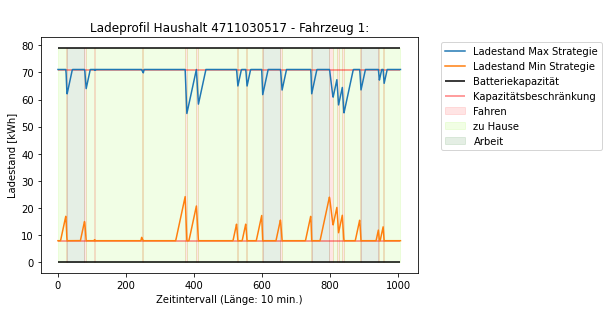





Household: 4701035981
Car: 1
Segment: [11]


Household: 4511020885
Car: 1
Segment: 3

Overall energy demand, Household 4511020885 , Car 1 [kWh]: 107.55595369999993

Home energy demand max strategy, Household 4511020885 , Car 1 [kWh]: 63.20170184999987

Work energy demand max strategy, Household 4511020885 , Car 1 [kWh]: 55.378737104249936

Home energy demand min strategy, Household 4511020885 , Car 1 [kWh]: 62.13999514210521

Work energy demand min strategy, Household 4511020885 , Car 1 [kWh]: 56.73763789473679




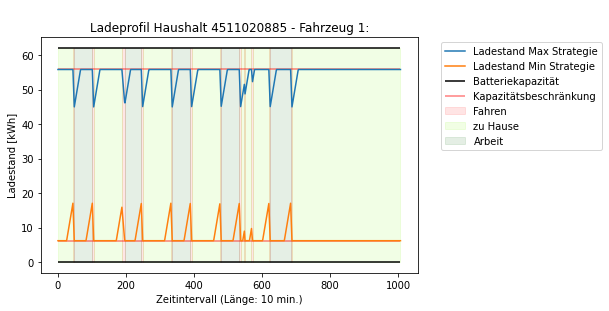





Household: 4511020331
Car: 1
Segment: [3]

Overall energy demand, Household 4511020331 , Car 1 [kWh]: 83.16286433333336

Home energy demand max strategy, Household 4511020331 , Car 1 [kWh]: 55.135243838499896

Work energy demand max strategy, Household 4511020331 , Car 1 [kWh]: 36.55181408899997

Home energy demand min strategy, Household 4511020331 , Car 1 [kWh]: 54.34597692631573

Work energy demand min strategy, Household 4511020331 , Car 1 [kWh]: 36.34062312631577




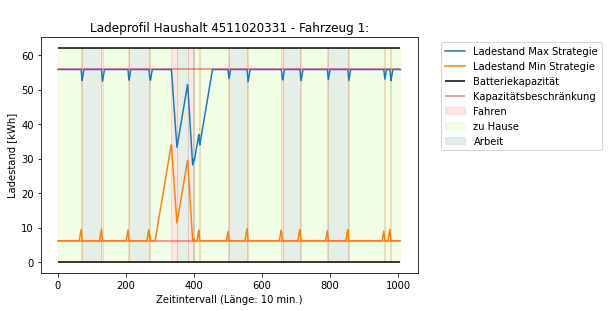





Household: 4501024234
Car: 1
Segment: [4]

Overall energy demand, Household 4501024234 , Car 1 [kWh]: 131.50861040000004

Home energy demand max strategy, Household 4501024234 , Car 1 [kWh]: 84.10113689250065

Work energy demand max strategy, Household 4501024234 , Car 1 [kWh]: 60.88710607350022

Home energy demand min strategy, Household 4501024234 , Car 1 [kWh]: 90.4603560736844

Work energy demand min strategy, Household 4501024234 , Car 1 [kWh]: 53.41845261052626




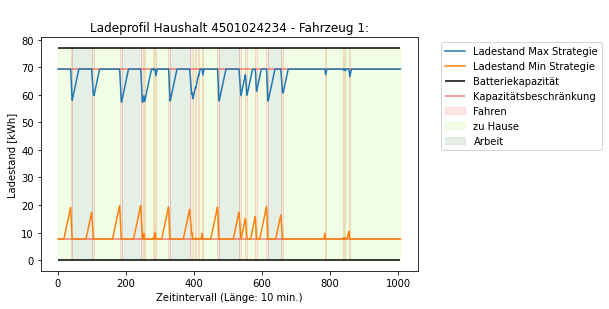





Household: 4501023822
Car: 1
Segment: 3

Overall energy demand, Household 4501023822 , Car 1 [kWh]: 124.6646034000001

Home energy demand max strategy, Household 4501023822 , Car 1 [kWh]: 97.49386551450027

Work energy demand max strategy, Household 4501023822 , Car 1 [kWh]: 33.22884792149999

Home energy demand min strategy, Household 4501023822 , Car 1 [kWh]: 73.95911776842114

Work energy demand min strategy, Household 4501023822 , Car 1 [kWh]: 60.715071568420996




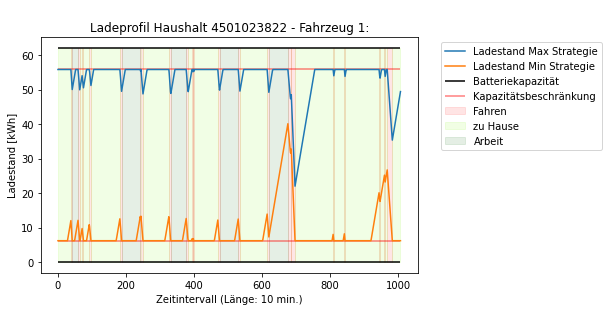





Household: 8711032028
Car: 1
Segment: [13]

Overall energy demand, Household 8711032028 , Car 1 [kWh]: 97.12019151666668

Home energy demand max strategy, Household 8711032028 , Car 1 [kWh]: 55.721531641125594

Work energy demand max strategy, Household 8711032028 , Car 1 [kWh]: 51.35347950600055

Home energy demand min strategy, Household 8711032028 , Car 1 [kWh]: 52.11769168421048

Work energy demand min strategy, Household 8711032028 , Car 1 [kWh]: 54.61055288684206




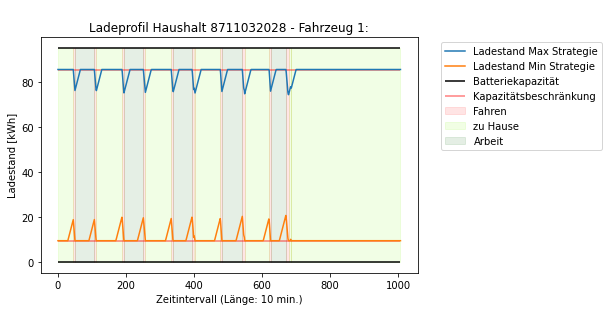





Household: 8711031249
Car: 1
Segment: [3]

Overall energy demand, Household 8711031249 , Car 1 [kWh]: 58.81792543333335

Home energy demand max strategy, Household 8711031249 , Car 1 [kWh]: 48.32498503174993

Work energy demand max strategy, Household 8711031249 , Car 1 [kWh]: 16.52177775850001

Home energy demand min strategy, Household 8711031249 , Car 1 [kWh]: 47.806336384210496

Work energy demand min strategy, Household 8711031249 , Car 1 [kWh]: 14.127324621052638




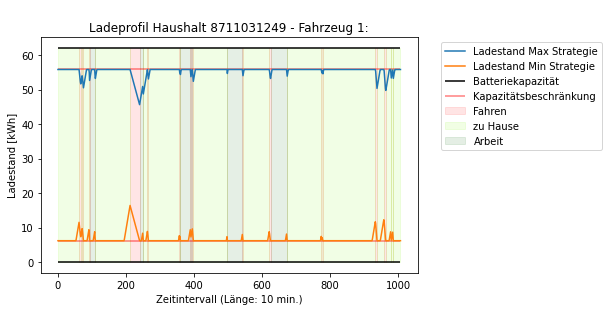





Household: 8711031105
Car: 1
Segment: [1]

Overall energy demand, Household 8711031105 , Car 1 [kWh]: 79.35023386666661

Home energy demand max strategy, Household 8711031105 , Car 1 [kWh]: 47.36316667424993

Work energy demand max strategy, Household 8711031105 , Car 1 [kWh]: 40.12046616374995

Home energy demand min strategy, Household 8711031105 , Car 1 [kWh]: 71.23717207894738

Work energy demand min strategy, Household 8711031105 , Car 1 [kWh]: 5.869532089473683




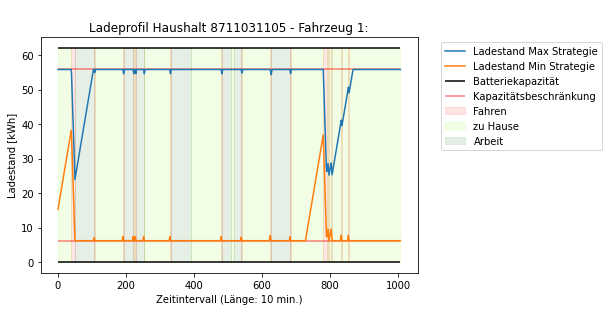





Household: 8701035896
Car: 1
Segment: [2]

Overall energy demand, Household 8701035896 , Car 1 [kWh]: 58.65624916666666

Home energy demand max strategy, Household 8701035896 , Car 1 [kWh]: 64.66851470624998

Work energy demand max strategy, Household 8701035896 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 8701035896 , Car 1 [kWh]: 64.21546618421047

Work energy demand min strategy, Household 8701035896 , Car 1 [kWh]: 0.0




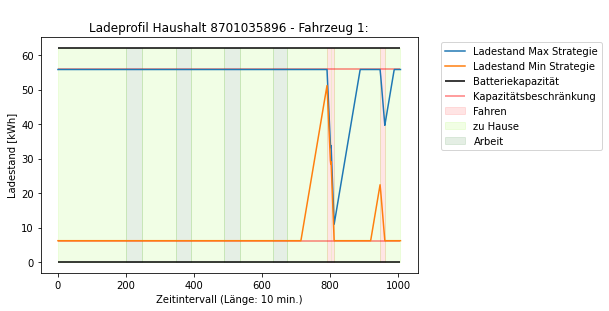





Household: 8701035540
Car: 1
Segment: [3]

Overall energy demand, Household 8701035540 , Car 1 [kWh]: 24.036054833333335

Home energy demand max strategy, Household 8701035540 , Car 1 [kWh]: 17.928329438249985

Work energy demand max strategy, Household 8701035540 , Car 1 [kWh]: 8.571421015500007

Home energy demand min strategy, Household 8701035540 , Car 1 [kWh]: 17.655912031578957

Work energy demand min strategy, Household 8701035540 , Car 1 [kWh]: 7.680003836842105




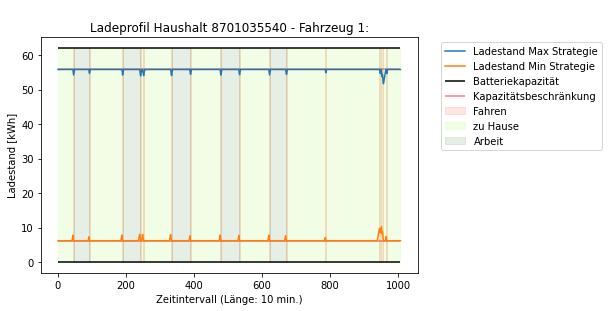





Household: 8511020387
Car: 1
Segment: [3]

Overall energy demand, Household 8511020387 , Car 1 [kWh]: 59.57956366666662

Home energy demand max strategy, Household 8511020387 , Car 1 [kWh]: 65.68646894249999

Work energy demand max strategy, Household 8511020387 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 8511020387 , Car 1 [kWh]: 60.930096684210504

Work energy demand min strategy, Household 8511020387 , Car 1 [kWh]: 0.0




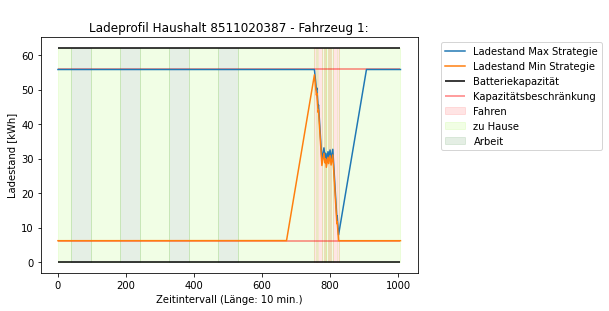





Household: 8311015369
Car: 1
Segment: [2]

Overall energy demand, Household 8311015369 , Car 1 [kWh]: 26.872783216666676

Home energy demand max strategy, Household 8311015369 , Car 1 [kWh]: 20.548723085624978

Work energy demand max strategy, Household 8311015369 , Car 1 [kWh]: 9.078520410749991

Home energy demand min strategy, Household 8311015369 , Car 1 [kWh]: 19.629863418421056

Work energy demand min strategy, Household 8311015369 , Car 1 [kWh]: 8.42636607105263




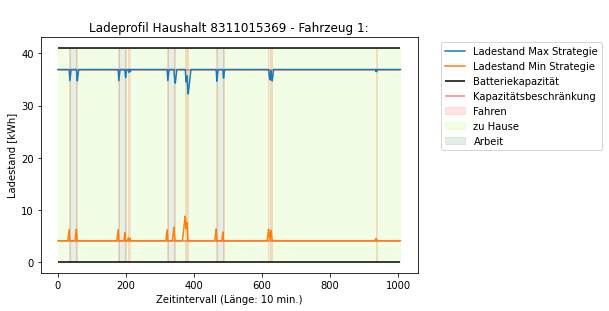





Household: 4711032221
Car: 1
Segment: [13]

Overall energy demand, Household 4711032221 , Car 1 [kWh]: 107.97387998333338

Home energy demand max strategy, Household 4711032221 , Car 1 [kWh]: 59.792476361625326

Work energy demand max strategy, Household 4711032221 , Car 1 [kWh]: 23.72988942625011

Home energy demand min strategy, Household 4711032221 , Car 1 [kWh]: 114.2747936657899

Work energy demand min strategy, Household 4711032221 , Car 1 [kWh]: 5.0647578947368395




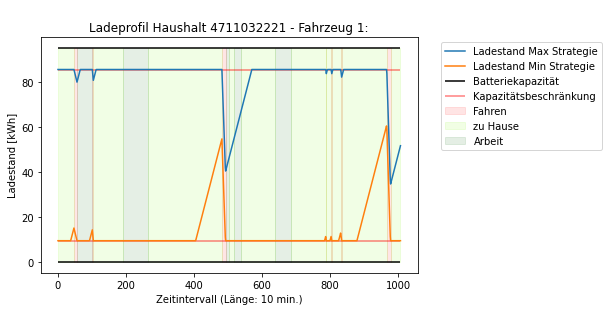





Household: 4711032145
Car: 1
Segment: [4]


Household: 4711032104
Car: 1
Segment: 3

Overall energy demand, Household 4711032104 , Car 1 [kWh]: 77.19874799999998

Home energy demand max strategy, Household 4711032104 , Car 1 [kWh]: 72.02593692000002

Work energy demand max strategy, Household 4711032104 , Car 1 [kWh]: 13.085682750000004

Home energy demand min strategy, Household 4711032104 , Car 1 [kWh]: 73.05527194736842

Work energy demand min strategy, Household 4711032104 , Car 1 [kWh]: 10.292827631578954




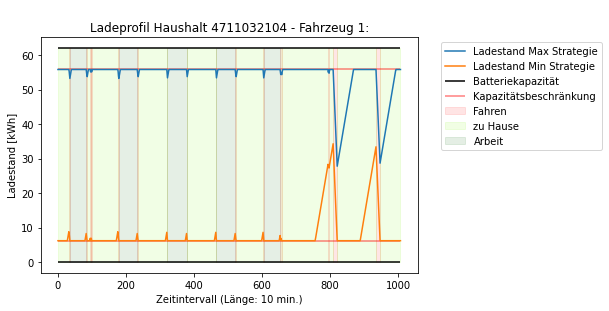





Household: 4711031936
Car: 1
Segment: [3]

Overall energy demand, Household 4711031936 , Car 1 [kWh]: 57.16700053333332

Home energy demand max strategy, Household 4711031936 , Car 1 [kWh]: 58.76041350899992

Work energy demand max strategy, Household 4711031936 , Car 1 [kWh]: 4.2662045789999965

Home energy demand min strategy, Household 4711031936 , Car 1 [kWh]: 47.59268956842101

Work energy demand min strategy, Household 4711031936 , Car 1 [kWh]: 11.133010736842103




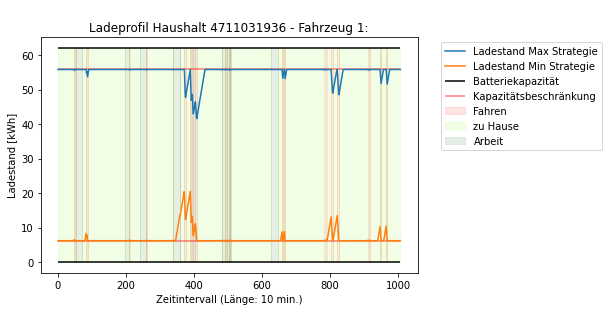





Household: 4711031640
Car: 1
Segment: [3]

Overall energy demand, Household 4711031640 , Car 1 [kWh]: 65.79091753333336

Home energy demand max strategy, Household 4711031640 , Car 1 [kWh]: 46.53216905924999

Work energy demand max strategy, Household 4711031640 , Car 1 [kWh]: 26.00231752125002

Home energy demand min strategy, Household 4711031640 , Car 1 [kWh]: 43.437233110526286

Work energy demand min strategy, Household 4711031640 , Car 1 [kWh]: 29.234288373684194




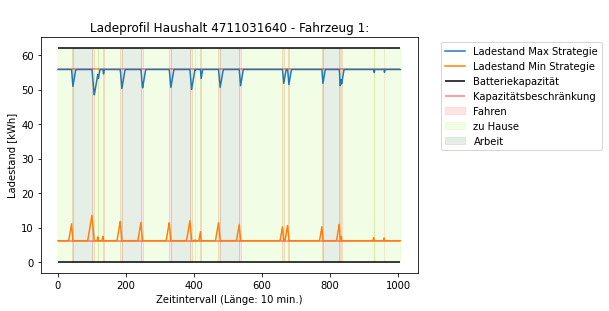





Household: 4711031419
Car: 1
Segment: [3]

Overall energy demand, Household 4711031419 , Car 1 [kWh]: 66.28641163333333

Home energy demand max strategy, Household 4711031419 , Car 1 [kWh]: 68.14435328049994

Work energy demand max strategy, Household 4711031419 , Car 1 [kWh]: 4.936415545249995

Home energy demand min strategy, Household 4711031419 , Car 1 [kWh]: 64.88430476315784

Work energy demand min strategy, Household 4711031419 , Car 1 [kWh]: 6.920407568421053




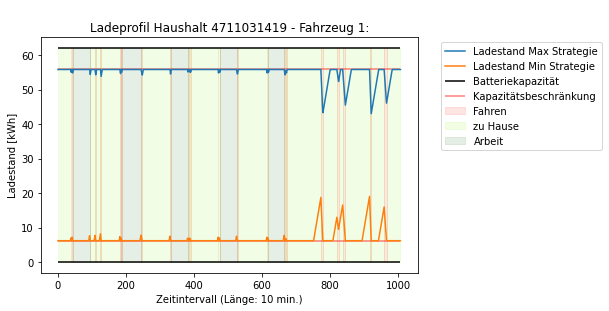





Household: 4711031198
Car: 1
Segment: [2]

Overall energy demand, Household 4711031198 , Car 1 [kWh]: 95.62555066666664

Home energy demand max strategy, Household 4711031198 , Car 1 [kWh]: 65.53941032624994

Work energy demand max strategy, Household 4711031198 , Car 1 [kWh]: 39.88775928374997

Home energy demand min strategy, Household 4711031198 , Car 1 [kWh]: 56.42871444736838

Work energy demand min strategy, Household 4711031198 , Car 1 [kWh]: 46.1870586578947




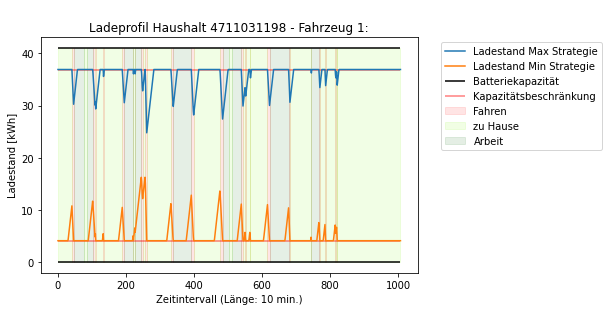





Household: 4711030937
Car: 1
Segment: 3

Overall energy demand, Household 4711030937 , Car 1 [kWh]: 20.691550999999997

Home energy demand max strategy, Household 4711030937 , Car 1 [kWh]: 19.901298427500013

Work energy demand max strategy, Household 4711030937 , Car 1 [kWh]: 2.9111365499999935

Home energy demand min strategy, Household 4711030937 , Car 1 [kWh]: 20.080847131578953

Work energy demand min strategy, Household 4711030937 , Car 1 [kWh]: 2.788761868421052




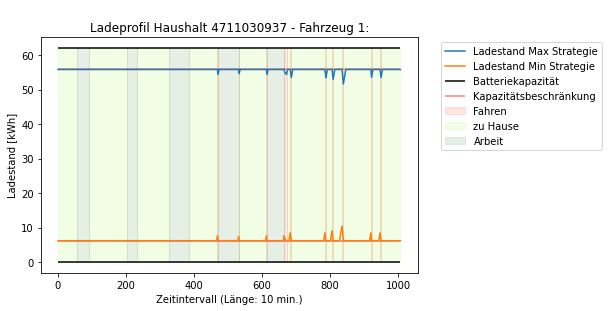





Household: 4711030900
Car: 1
Segment: [5]

Overall energy demand, Household 4711030900 , Car 1 [kWh]: 1.63421

Home energy demand max strategy, Household 4711030900 , Car 1 [kWh]: 1.8017165250000104

Work energy demand max strategy, Household 4711030900 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 4711030900 , Car 1 [kWh]: 1.8062321052631605

Work energy demand min strategy, Household 4711030900 , Car 1 [kWh]: 0.0




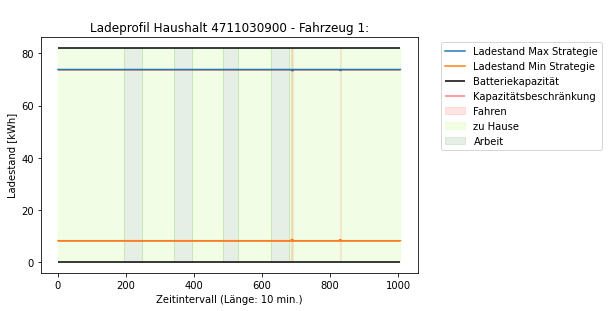





Household: 4711030608
Car: 1
Segment: 3

Overall energy demand, Household 4711030608 , Car 1 [kWh]: 117.36473469999994

Home energy demand max strategy, Household 4711030608 , Car 1 [kWh]: 69.09123667249996

Work energy demand max strategy, Household 4711030608 , Car 1 [kWh]: 60.30338333424995

Home energy demand min strategy, Household 4711030608 , Car 1 [kWh]: 74.65981054736845

Work energy demand min strategy, Household 4711030608 , Car 1 [kWh]: 53.82885675263152




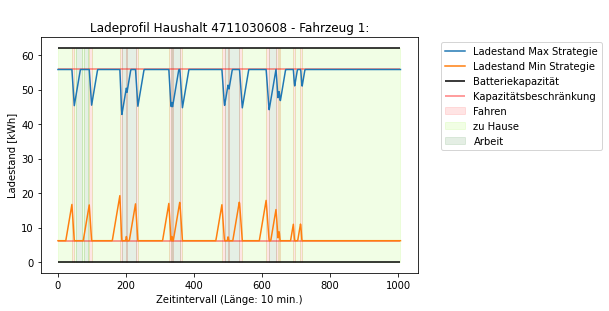





Household: 4711030459
Car: 1
Segment: 3

Overall energy demand, Household 4711030459 , Car 1 [kWh]: 59.74847043333334

Home energy demand max strategy, Household 4711030459 , Car 1 [kWh]: 44.91323828774996

Work energy demand max strategy, Household 4711030459 , Car 1 [kWh]: 20.959450365

Home energy demand min strategy, Household 4711030459 , Car 1 [kWh]: 42.489315142105234

Work energy demand min strategy, Household 4711030459 , Car 1 [kWh]: 21.08796796842105




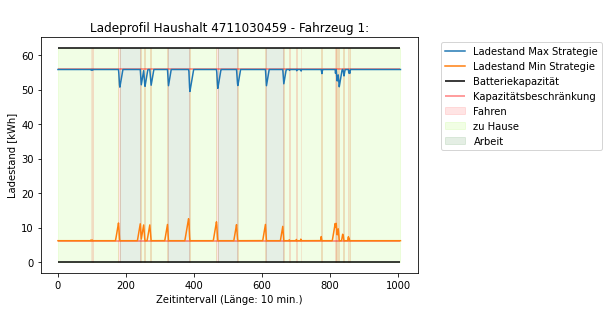





Household: 4701036022
Car: 1
Segment: 3

Overall energy demand, Household 4701036022 , Car 1 [kWh]: 14.277211999999999

Home energy demand max strategy, Household 4701036022 , Car 1 [kWh]: 8.718977924999995

Work energy demand max strategy, Household 4701036022 , Car 1 [kWh]: 7.021648305000006

Home energy demand min strategy, Household 4701036022 , Car 1 [kWh]: 8.090689526315789

Work energy demand min strategy, Household 4701036022 , Car 1 [kWh]: 7.650034736842108




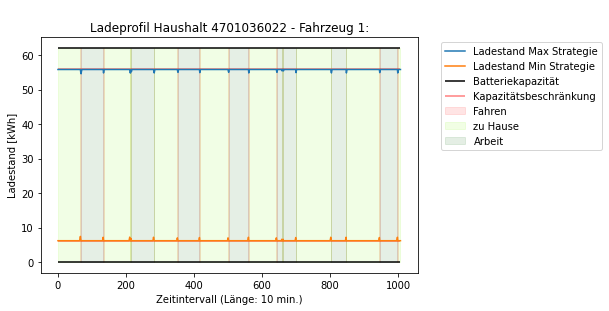





Household: 4701034993
Car: 1
Segment: [4]

Overall energy demand, Household 4701034993 , Car 1 [kWh]: 79.63721126666665

Home energy demand max strategy, Household 4701034993 , Car 1 [kWh]: 52.95922390150049

Work energy demand max strategy, Household 4701034993 , Car 1 [kWh]: 34.8408015200003

Home energy demand min strategy, Household 4701034993 , Car 1 [kWh]: 52.99462729473679

Work energy demand min strategy, Household 4701034993 , Car 1 [kWh]: 34.18498963157893




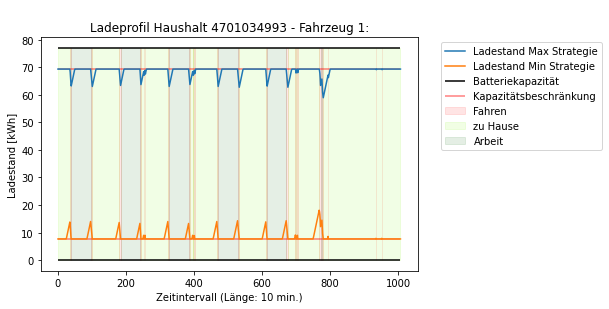





Household: 4701034973
Car: 1
Segment: [5]

Overall energy demand, Household 4701034973 , Car 1 [kWh]: 57.367701666666655

Home energy demand max strategy, Household 4701034973 , Car 1 [kWh]: 48.22546099000023

Work energy demand max strategy, Household 4701034973 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 4701034973 , Car 1 [kWh]: 41.508573013157864

Work energy demand min strategy, Household 4701034973 , Car 1 [kWh]: 17.77256682894737




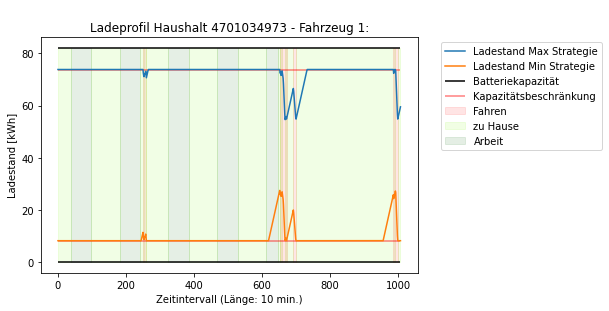





Household: 4701034955
Car: 1
Segment: 3

Overall energy demand, Household 4701034955 , Car 1 [kWh]: 78.78204896666668

Home energy demand max strategy, Household 4701034955 , Car 1 [kWh]: 40.56215691675002

Work energy demand max strategy, Household 4701034955 , Car 1 [kWh]: 46.29505206899996

Home energy demand min strategy, Household 4701034955 , Car 1 [kWh]: 55.976342210526276

Work energy demand min strategy, Household 4701034955 , Car 1 [kWh]: 29.02961633157893




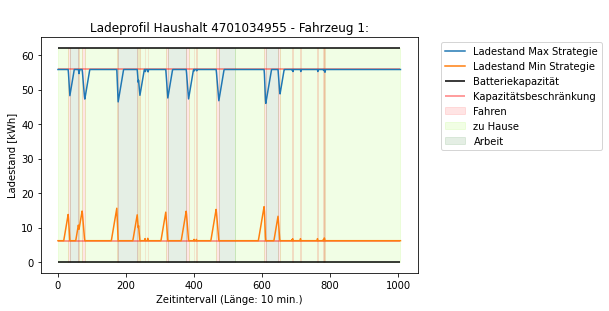





Household: 4701034745
Car: 1
Segment: 3

Overall energy demand, Household 4701034745 , Car 1 [kWh]: 150.02599746666664

Home energy demand max strategy, Household 4701034745 , Car 1 [kWh]: 84.44283159375011

Work energy demand max strategy, Household 4701034745 , Car 1 [kWh]: 80.96083061325011

Home energy demand min strategy, Household 4701034745 , Car 1 [kWh]: 81.78426859473691

Work energy demand min strategy, Household 4701034745 , Car 1 [kWh]: 83.50551576315803




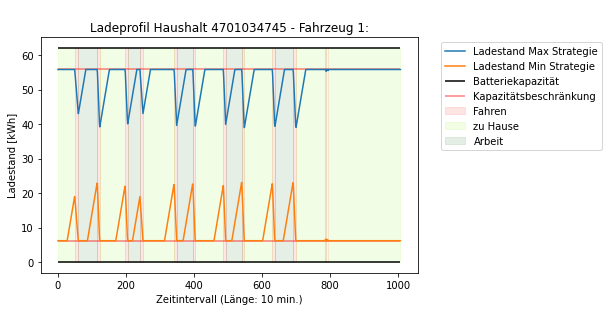





Household: 4701034291
Car: 1
Segment: [3]

Overall energy demand, Household 4701034291 , Car 1 [kWh]: 30.438447900000003

Home energy demand max strategy, Household 4701034291 , Car 1 [kWh]: 18.855878364749994

Work energy demand max strategy, Household 4701034291 , Car 1 [kWh]: 14.702510445

Home energy demand min strategy, Household 4701034291 , Car 1 [kWh]: 21.207411363157895

Work energy demand min strategy, Household 4701034291 , Car 1 [kWh]: 11.819958684210532




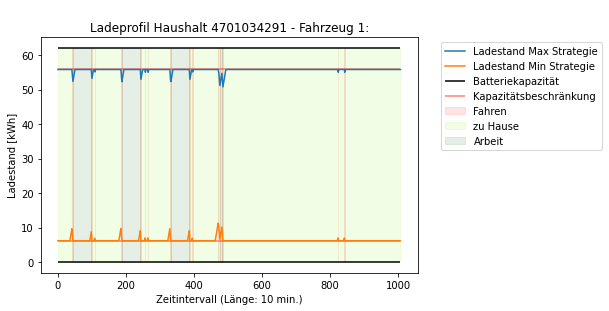





Household: 4701034271
Car: 1
Segment: [2]

Overall energy demand, Household 4701034271 , Car 1 [kWh]: 24.179273366666663

Home energy demand max strategy, Household 4701034271 , Car 1 [kWh]: 21.25411243462502

Work energy demand max strategy, Household 4701034271 , Car 1 [kWh]: 5.40353645212502

Home energy demand min strategy, Household 4701034271 , Car 1 [kWh]: 19.837341650000006

Work energy demand min strategy, Household 4701034271 , Car 1 [kWh]: 6.04761667631579




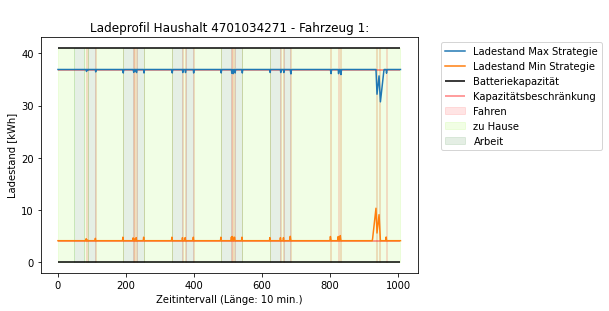





Household: 4701033995
Car: 1
Segment: [3]

Overall energy demand, Household 4701033995 , Car 1 [kWh]: 8.954885

Home energy demand max strategy, Household 4701033995 , Car 1 [kWh]: 9.872760712499982

Work energy demand max strategy, Household 4701033995 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 4701033995 , Car 1 [kWh]: 9.819840763157897

Work energy demand min strategy, Household 4701033995 , Car 1 [kWh]: 0.0




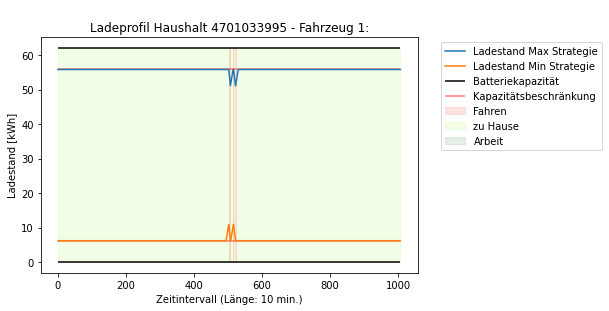





Household: 4701033886
Car: 1
Segment: [3]

Overall energy demand, Household 4701033886 , Car 1 [kWh]: 27.3260615

Home energy demand max strategy, Household 4701033886 , Car 1 [kWh]: 30.126982803749996

Work energy demand max strategy, Household 4701033886 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 4701033886 , Car 1 [kWh]: 29.398292847368403

Work energy demand min strategy, Household 4701033886 , Car 1 [kWh]: 0.0




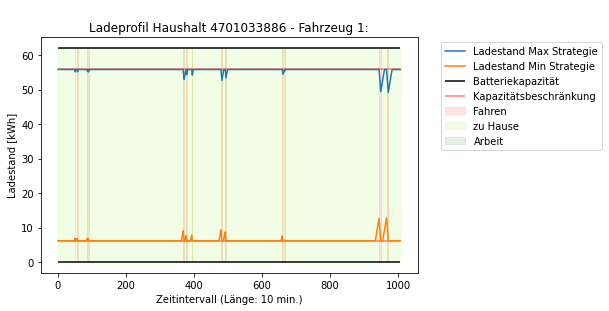





Household: 4701033880
Car: 1
Segment: [1]

Overall energy demand, Household 4701033880 , Car 1 [kWh]: 68.19449751666671

Home energy demand max strategy, Household 4701033880 , Car 1 [kWh]: 61.02939779212495

Work energy demand max strategy, Household 4701033880 , Car 1 [kWh]: 14.155035720000013

Home energy demand min strategy, Household 4701033880 , Car 1 [kWh]: 57.07816484999996

Work energy demand min strategy, Household 4701033880 , Car 1 [kWh]: 15.391762786842113




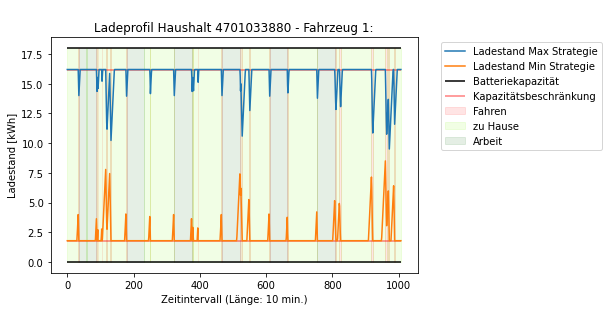





Household: 4701032412
Car: 1
Segment: [4]

Overall energy demand, Household 4701032412 , Car 1 [kWh]: 21.158161200000002

Home energy demand max strategy, Household 4701032412 , Car 1 [kWh]: 15.127348183500157

Work energy demand max strategy, Household 4701032412 , Car 1 [kWh]: 8.199524539500038

Home energy demand min strategy, Household 4701032412 , Car 1 [kWh]: 15.269154600000006

Work energy demand min strategy, Household 4701032412 , Car 1 [kWh]: 8.116181463157893




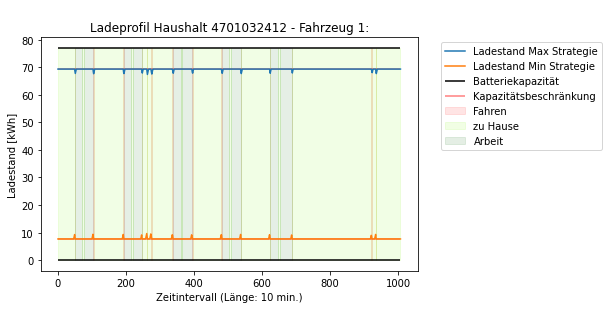





Household: 4511021845
Car: 1
Segment: 3

Overall energy demand, Household 4511021845 , Car 1 [kWh]: 27.807235999999996

Home energy demand max strategy, Household 4511021845 , Car 1 [kWh]: 30.657477690000032

Work energy demand max strategy, Household 4511021845 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 4511021845 , Car 1 [kWh]: 29.64611189473683

Work energy demand min strategy, Household 4511021845 , Car 1 [kWh]: 0.0




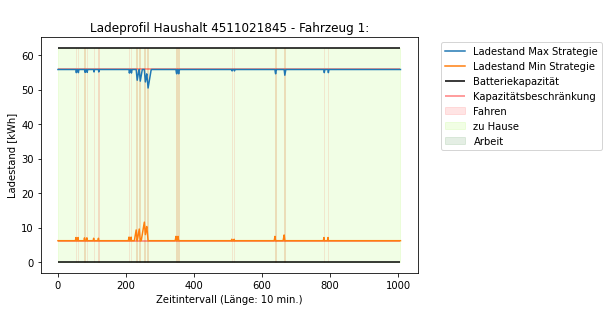





Household: 4511021704
Car: 1
Segment: [3]

Overall energy demand, Household 4511021704 , Car 1 [kWh]: 0.5285336666666667

Home energy demand max strategy, Household 4511021704 , Car 1 [kWh]: 0.5827083675000019

Work energy demand max strategy, Household 4511021704 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 4511021704 , Car 1 [kWh]: 0.5841687894736842

Work energy demand min strategy, Household 4511021704 , Car 1 [kWh]: 0.0




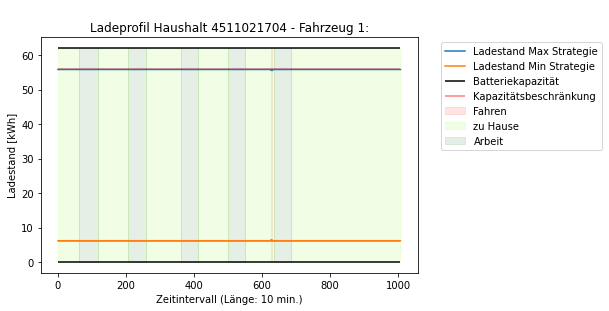





Household: 4511021288
Car: 1
Segment: [1]

Overall energy demand, Household 4511021288 , Car 1 [kWh]: 69.38783674999999

Home energy demand max strategy, Household 4511021288 , Car 1 [kWh]: 56.520332229374965

Work energy demand max strategy, Household 4511021288 , Car 1 [kWh]: 16.758751537500004

Home energy demand min strategy, Household 4511021288 , Car 1 [kWh]: 68.30956438157894

Work energy demand min strategy, Household 4511021288 , Car 1 [kWh]: 6.399875631578947




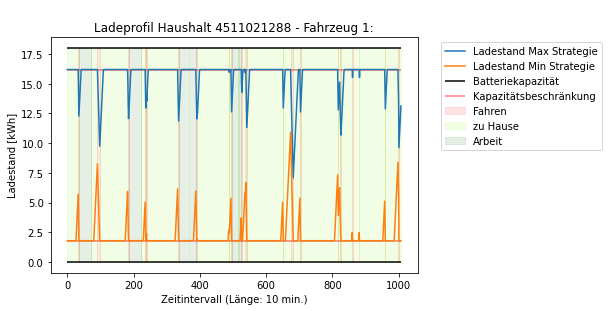





Household: 4511021194
Car: 1
Segment: 3

Overall energy demand, Household 4511021194 , Car 1 [kWh]: 67.16443206666668

Home energy demand max strategy, Household 4511021194 , Car 1 [kWh]: 39.00522512249995

Work energy demand max strategy, Household 4511021194 , Car 1 [kWh]: 35.043561230999984

Home energy demand min strategy, Household 4511021194 , Car 1 [kWh]: 41.073660489473646

Work energy demand min strategy, Household 4511021194 , Car 1 [kWh]: 33.16071179473681




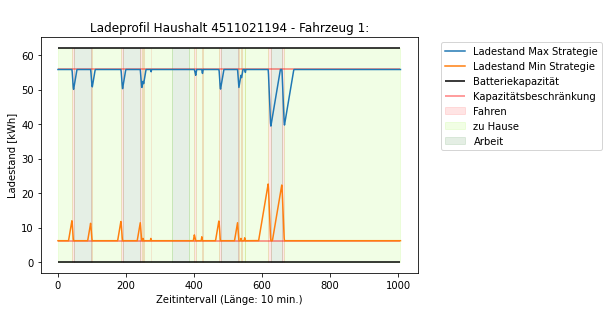





Household: 4511021061
Car: 1
Segment: [13]

Overall energy demand, Household 4511021061 , Car 1 [kWh]: 26.997960499999994

Home energy demand max strategy, Household 4511021061 , Car 1 [kWh]: 22.362038627250236

Work energy demand max strategy, Household 4511021061 , Car 1 [kWh]: 7.403212824000066

Home energy demand min strategy, Household 4511021061 , Car 1 [kWh]: 22.32711686578947

Work energy demand min strategy, Household 4511021061 , Car 1 [kWh]: 5.717864360526314




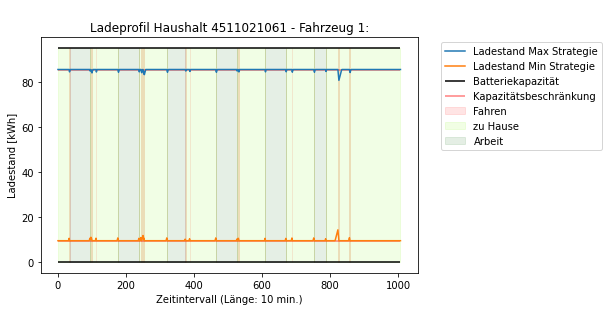





Household: 4501026430
Car: 1
Segment: [2]

Overall energy demand, Household 4501026430 , Car 1 [kWh]: 73.98824350000005

Home energy demand max strategy, Household 4501026430 , Car 1 [kWh]: 43.401544291875

Work energy demand max strategy, Household 4501026430 , Car 1 [kWh]: 38.170494166874974

Home energy demand min strategy, Household 4501026430 , Car 1 [kWh]: 42.568039776315764

Work energy demand min strategy, Household 4501026430 , Car 1 [kWh]: 37.97818988157892




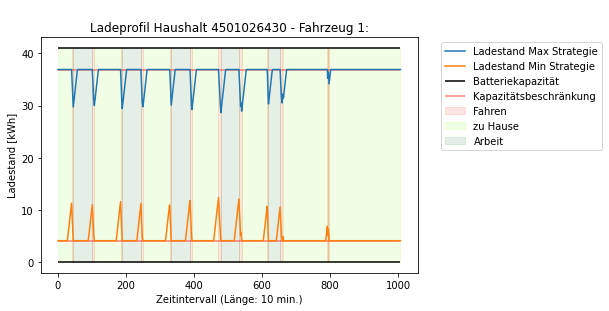





Household: 4501026225
Car: 1
Segment: 3

Overall energy demand, Household 4501026225 , Car 1 [kWh]: 36.08159163333334

Home energy demand max strategy, Household 4501026225 , Car 1 [kWh]: 31.12164000224997

Work energy demand max strategy, Household 4501026225 , Car 1 [kWh]: 8.658314773499985

Home energy demand min strategy, Household 4501026225 , Car 1 [kWh]: 14.93311038947369

Work energy demand min strategy, Household 4501026225 , Car 1 [kWh]: 22.486043521052625




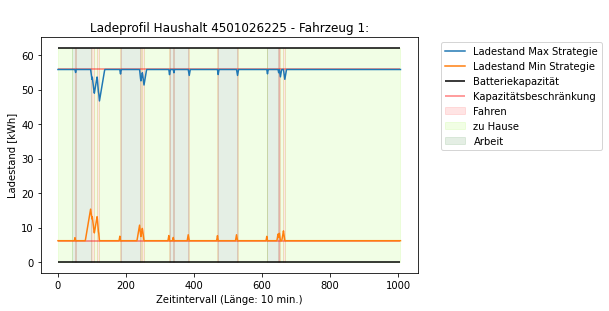





Household: 4501026087
Car: 1
Segment: [4]

Overall energy demand, Household 4501026087 , Car 1 [kWh]: 32.36792719999999

Home energy demand max strategy, Household 4501026087 , Car 1 [kWh]: 16.96116406950017

Work energy demand max strategy, Household 4501026087 , Car 1 [kWh]: 18.724475668500162

Home energy demand min strategy, Household 4501026087 , Car 1 [kWh]: 19.104461231578952

Work energy demand min strategy, Household 4501026087 , Car 1 [kWh]: 16.337559147368427




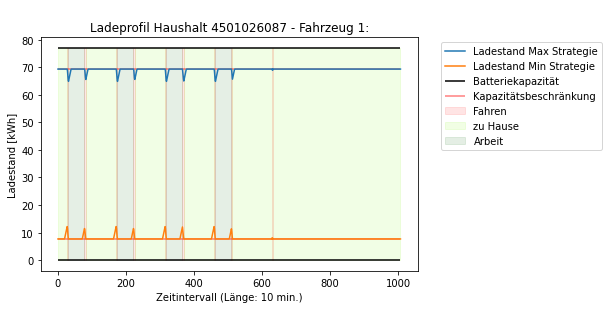





Household: 4501025706
Car: 1
Segment: [2]

Overall energy demand, Household 4501025706 , Car 1 [kWh]: 54.21298456666668

Home energy demand max strategy, Household 4501025706 , Car 1 [kWh]: 31.75443580837499

Work energy demand max strategy, Household 4501025706 , Car 1 [kWh]: 28.015379676374998

Home energy demand min strategy, Household 4501025706 , Car 1 [kWh]: 32.032633573684194

Work energy demand min strategy, Household 4501025706 , Car 1 [kWh]: 27.37985793421052




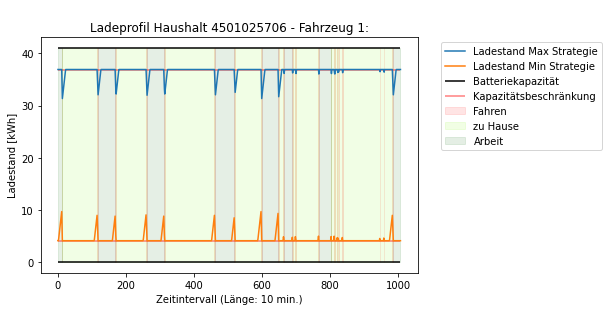





Household: 4501025246
Car: 1
Segment: [2]

Overall energy demand, Household 4501025246 , Car 1 [kWh]: 10.735799916666668

Home energy demand max strategy, Household 4501025246 , Car 1 [kWh]: 9.846932904375013

Work energy demand max strategy, Household 4501025246 , Car 1 [kWh]: 1.9892865037500052

Home energy demand min strategy, Household 4501025246 , Car 1 [kWh]: 8.916339434210528

Work energy demand min strategy, Household 4501025246 , Car 1 [kWh]: 2.9495446842105255




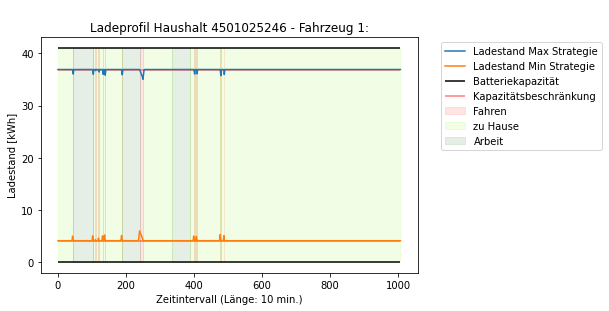





Household: 4501024646
Car: 1
Segment: [1]

Overall energy demand, Household 4501024646 , Car 1 [kWh]: 31.105695933333333

Home energy demand max strategy, Household 4501024646 , Car 1 [kWh]: 21.481504345875003

Work energy demand max strategy, Household 4501024646 , Car 1 [kWh]: 12.812525420625002

Home energy demand min strategy, Household 4501024646 , Car 1 [kWh]: 17.93094680263158

Work energy demand min strategy, Household 4501024646 , Car 1 [kWh]: 14.637084497368427




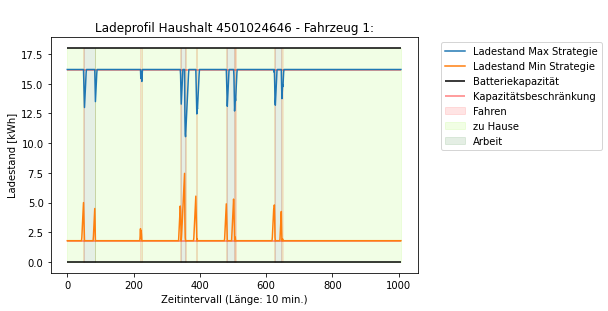





Household: 4501024210
Car: 1
Segment: [10]

Overall energy demand, Household 4501024210 , Car 1 [kWh]: 115.26306793333333

Home energy demand max strategy, Household 4501024210 , Car 1 [kWh]: 98.46236697150076

Work energy demand max strategy, Household 4501024210 , Car 1 [kWh]: 8.974663110000105

Home energy demand min strategy, Household 4501024210 , Car 1 [kWh]: 105.48717295789505

Work energy demand min strategy, Household 4501024210 , Car 1 [kWh]: 20.560821915789475




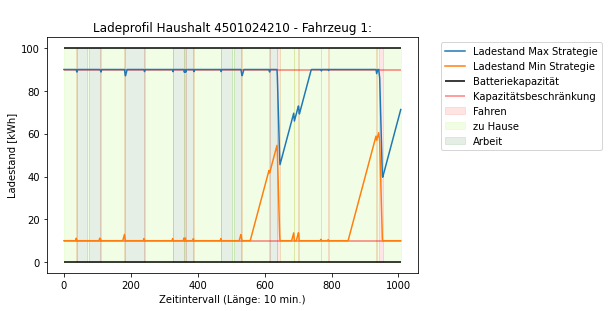





Household: 4501024009
Car: 1
Segment: [2]

Overall energy demand, Household 4501024009 , Car 1 [kWh]: 47.81894379999998

Home energy demand max strategy, Household 4501024009 , Car 1 [kWh]: 49.992998989499995

Work energy demand max strategy, Household 4501024009 , Car 1 [kWh]: 2.7273865499999967

Home energy demand min strategy, Household 4501024009 , Car 1 [kWh]: 20.776505252631573

Work energy demand min strategy, Household 4501024009 , Car 1 [kWh]: 32.07601157894735




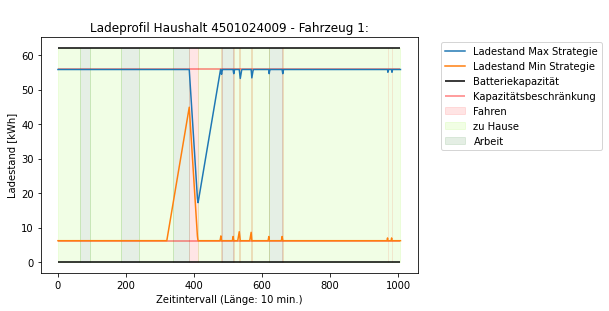





Household: 4501023994
Car: 1
Segment: [4]

Overall energy demand, Household 4501023994 , Car 1 [kWh]: 84.24624200000005

Home energy demand max strategy, Household 4501023994 , Car 1 [kWh]: 58.27274260500035

Work energy demand max strategy, Household 4501023994 , Car 1 [kWh]: 34.60873920000026

Home energy demand min strategy, Household 4501023994 , Car 1 [kWh]: 57.99974378947361

Work energy demand min strategy, Household 4501023994 , Car 1 [kWh]: 35.11452368421052




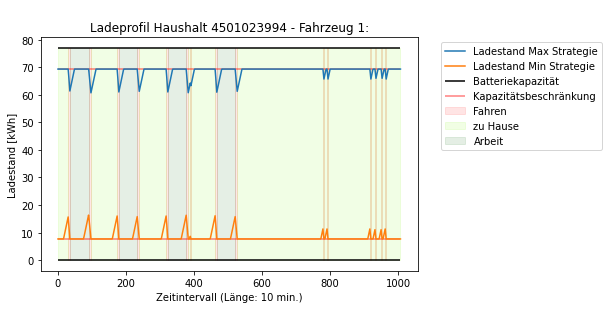





Household: 4501023143
Car: 1
Segment: [3]

Overall energy demand, Household 4501023143 , Car 1 [kWh]: 30.517551366666666

Home energy demand max strategy, Household 4501023143 , Car 1 [kWh]: 24.352390881000012

Work energy demand max strategy, Household 4501023143 , Car 1 [kWh]: 9.293209500750008

Home energy demand min strategy, Household 4501023143 , Car 1 [kWh]: 20.65014217368421

Work energy demand min strategy, Household 4501023143 , Car 1 [kWh]: 12.419902231578952




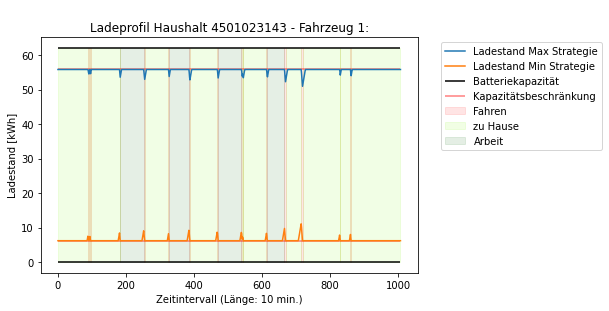





Household: 4501022793
Car: 1
Segment: 3

Overall energy demand, Household 4501022793 , Car 1 [kWh]: 25.659144

Home energy demand max strategy, Household 4501022793 , Car 1 [kWh]: 20.861478539999986

Work energy demand max strategy, Household 4501022793 , Car 1 [kWh]: 7.427727719999977

Home energy demand min strategy, Household 4501022793 , Car 1 [kWh]: 17.350593473684214

Work energy demand min strategy, Household 4501022793 , Car 1 [kWh]: 9.393867736842106




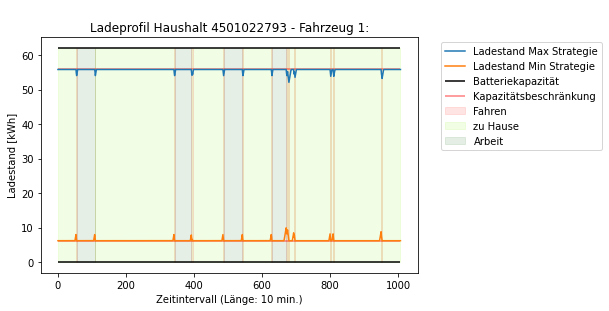





Household: 4501022653
Car: 1
Segment: [4]

Overall energy demand, Household 4501022653 , Car 1 [kWh]: 53.853955933333346

Home energy demand max strategy, Household 4501022653 , Car 1 [kWh]: 26.857144184500278

Work energy demand max strategy, Household 4501022653 , Car 1 [kWh]: 32.516842232000386

Home energy demand min strategy, Household 4501022653 , Car 1 [kWh]: 26.980193505263156

Work energy demand min strategy, Household 4501022653 , Car 1 [kWh]: 31.09976873684209




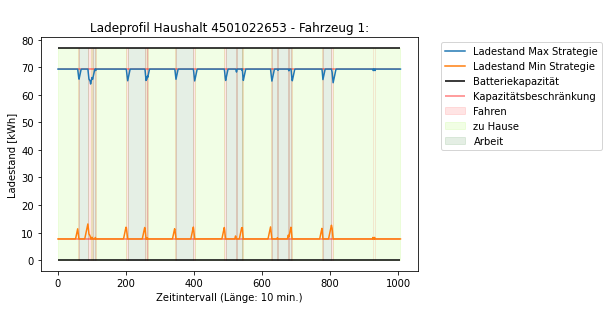





Household: 4311011454
Car: 1
Segment: [3]

Overall energy demand, Household 4311011454 , Car 1 [kWh]: 25.533791333333333

Home energy demand max strategy, Household 4311011454 , Car 1 [kWh]: 19.72101064499997

Work energy demand max strategy, Household 4311011454 , Car 1 [kWh]: 8.429994299999981

Home energy demand min strategy, Household 4311011454 , Car 1 [kWh]: 14.951066052631584

Work energy demand min strategy, Household 4311011454 , Car 1 [kWh]: 12.655367789473688




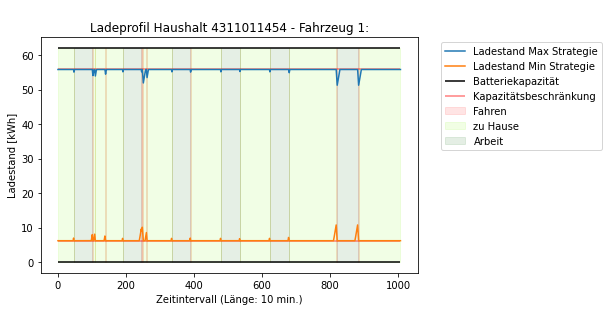





Household: 4311011155
Car: 1
Segment: 3

Overall energy demand, Household 4311011155 , Car 1 [kWh]: 85.87215456666664

Home energy demand max strategy, Household 4311011155 , Car 1 [kWh]: 87.05919315975018

Work energy demand max strategy, Household 4311011155 , Car 1 [kWh]: 7.614857249999994

Home energy demand min strategy, Household 4311011155 , Car 1 [kWh]: 85.07725689473699

Work energy demand min strategy, Household 4311011155 , Car 1 [kWh]: 8.603821836842105




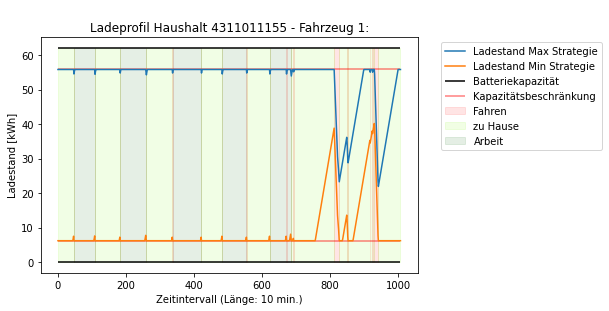





Household: 4301015137
Car: 1
Segment: [11]


Household: 4301013963
Car: 1
Segment: [3]

Overall energy demand, Household 4301013963 , Car 1 [kWh]: 39.53350239999999

Home energy demand max strategy, Household 4301013963 , Car 1 [kWh]: 30.20251607099997

Work energy demand max strategy, Household 4301013963 , Car 1 [kWh]: 13.383170324999993

Home energy demand min strategy, Household 4301013963 , Car 1 [kWh]: 28.432836599999987

Work energy demand min strategy, Household 4301013963 , Car 1 [kWh]: 13.41671210526316




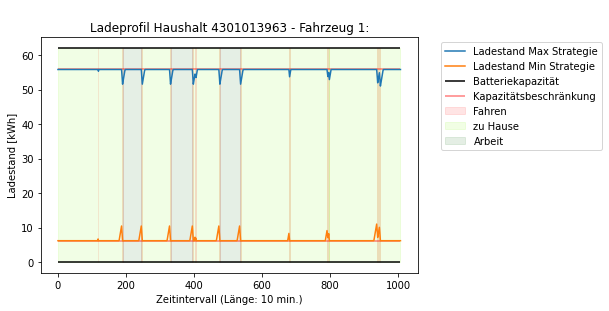





Household: 4301013576
Car: 1
Segment: 3

Overall energy demand, Household 4301013576 , Car 1 [kWh]: 33.619005633333316

Home energy demand max strategy, Household 4301013576 , Car 1 [kWh]: 20.646288510749958

Work energy demand max strategy, Household 4301013576 , Car 1 [kWh]: 16.418665199999975

Home energy demand min strategy, Household 4301013576 , Car 1 [kWh]: 19.719329184210533

Work energy demand min strategy, Household 4301013576 , Car 1 [kWh]: 16.6440252631579




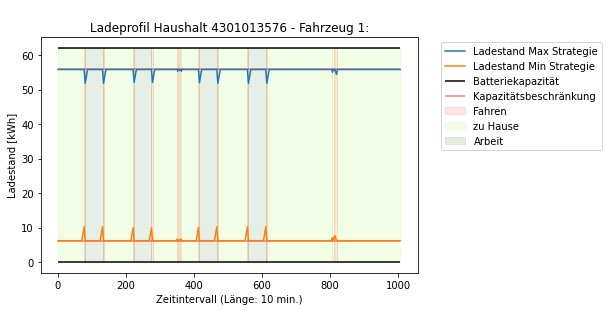





Household: 4301012983
Car: 1
Segment: [3]

Overall energy demand, Household 4301012983 , Car 1 [kWh]: 66.4113943333333

Home energy demand max strategy, Household 4301012983 , Car 1 [kWh]: 38.23371142499993

Work energy demand max strategy, Household 4301012983 , Car 1 [kWh]: 34.9848508275

Home energy demand min strategy, Household 4301012983 , Car 1 [kWh]: 35.51425389473681

Work energy demand min strategy, Household 4301012983 , Car 1 [kWh]: 37.27268852631576




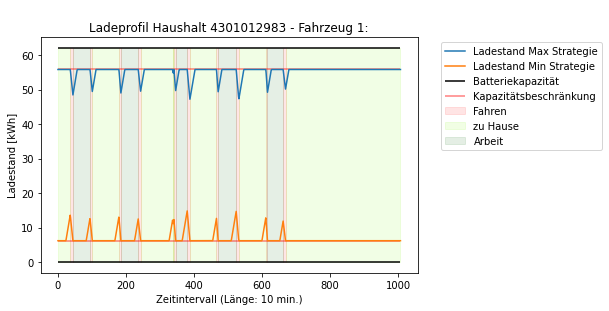





Household: 4301011882
Car: 1
Segment: 3

Overall energy demand, Household 4301011882 , Car 1 [kWh]: 46.164135366666684

Home energy demand max strategy, Household 4301011882 , Car 1 [kWh]: 40.03728437624995

Work energy demand max strategy, Household 4301011882 , Car 1 [kWh]: 10.858674865499978

Home energy demand min strategy, Household 4301011882 , Car 1 [kWh]: 37.614674078947345

Work energy demand min strategy, Household 4301011882 , Car 1 [kWh]: 11.358529515789476




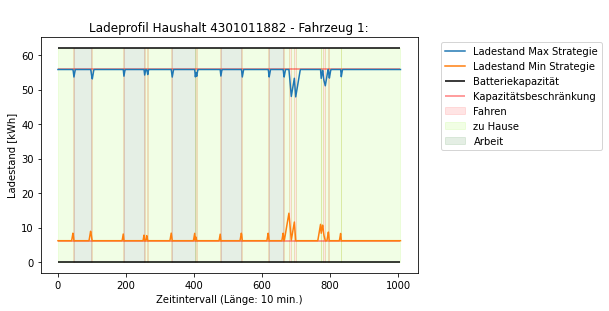





Household: 4701033867
Car: 1
Segment: [3]

Overall energy demand, Household 4701033867 , Car 1 [kWh]: 114.91178440000004

Home energy demand max strategy, Household 4701033867 , Car 1 [kWh]: 112.13683070100038

Work energy demand max strategy, Household 4701033867 , Car 1 [kWh]: 14.553411600000025

Home energy demand min strategy, Household 4701033867 , Car 1 [kWh]: 109.50604257894773

Work energy demand min strategy, Household 4701033867 , Car 1 [kWh]: 14.892465073684239




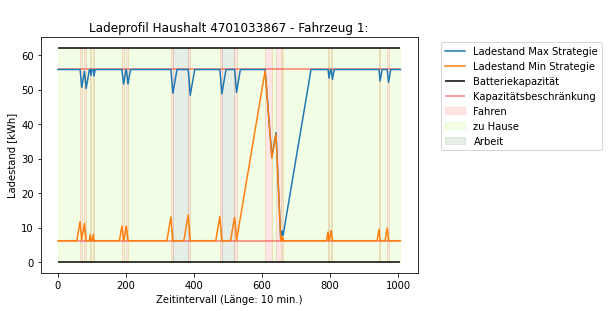





Household: 4501024727
Car: 1
Segment: [4]

Overall energy demand, Household 4501024727 , Car 1 [kWh]: 130.1762152

Home energy demand max strategy, Household 4501024727 , Car 1 [kWh]: 77.67060366450049

Work energy demand max strategy, Household 4501024727 , Car 1 [kWh]: 65.84867359350025

Home energy demand min strategy, Household 4501024727 , Car 1 [kWh]: 79.95394112631587

Work energy demand min strategy, Household 4501024727 , Car 1 [kWh]: 62.69478356842098




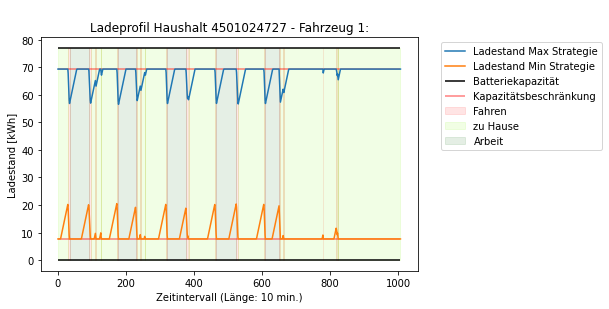





Household: 4501024541
Car: 1
Segment: [8]


Household: 8711032039
Car: 1
Segment: [2]

Overall energy demand, Household 8711032039 , Car 1 [kWh]: 45.435299166666674

Home energy demand max strategy, Household 8711032039 , Car 1 [kWh]: 36.02441580499997

Work energy demand max strategy, Household 8711032039 , Car 1 [kWh]: 14.068001526249988

Home energy demand min strategy, Household 8711032039 , Car 1 [kWh]: 32.002274499999984

Work energy demand min strategy, Household 8711032039 , Car 1 [kWh]: 16.370312736842113




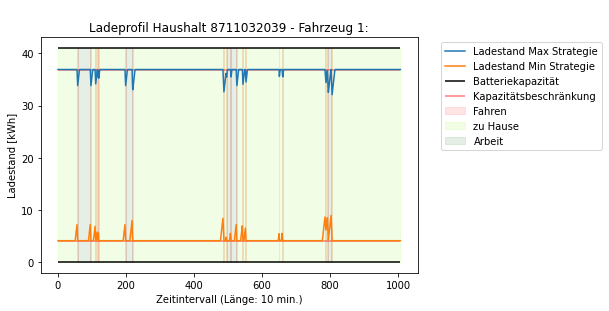





Household: 8711030893
Car: 1
Segment: [9]

Overall energy demand, Household 8711030893 , Car 1 [kWh]: 48.36743710000002

Home energy demand max strategy, Household 8711030893 , Car 1 [kWh]: 29.876233272374986

Work energy demand max strategy, Household 8711030893 , Car 1 [kWh]: 23.448866130374988

Home energy demand min strategy, Household 8711030893 , Car 1 [kWh]: 26.465660586842098

Work energy demand min strategy, Household 8711030893 , Car 1 [kWh]: 26.377960681578948




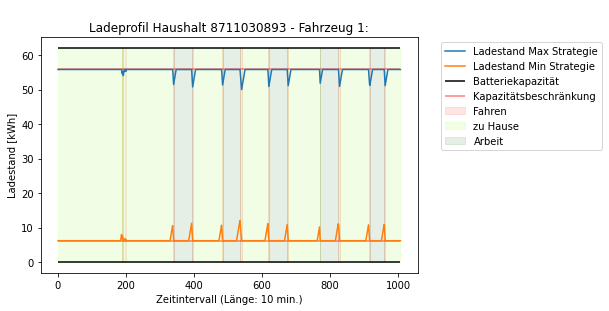





Household: 8711030806
Car: 1
Segment: [2]

Overall energy demand, Household 8711030806 , Car 1 [kWh]: 26.967998350000006

Home energy demand max strategy, Household 8711030806 , Car 1 [kWh]: 19.42387111087501

Work energy demand max strategy, Household 8711030806 , Car 1 [kWh]: 10.308347070000005

Home energy demand min strategy, Household 8711030806 , Car 1 [kWh]: 16.40393880263159

Work energy demand min strategy, Household 8711030806 , Car 1 [kWh]: 13.40279621578948




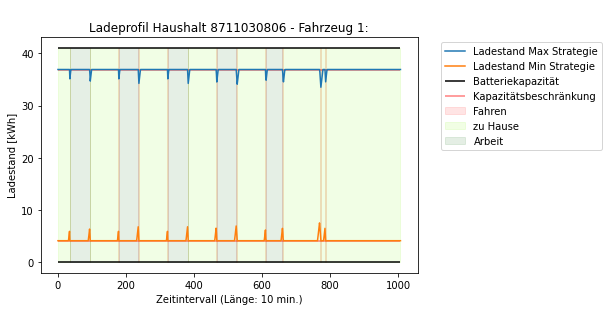





Household: 8701035936
Car: 1
Segment: [3]

Overall energy demand, Household 8701035936 , Car 1 [kWh]: 52.65641466666665

Home energy demand max strategy, Household 8701035936 , Car 1 [kWh]: 51.670852799999984

Work energy demand max strategy, Household 8701035936 , Car 1 [kWh]: 6.3828443700000115

Home energy demand min strategy, Household 8701035936 , Car 1 [kWh]: 46.41680926842102

Work energy demand min strategy, Household 8701035936 , Car 1 [kWh]: 9.321885889473686




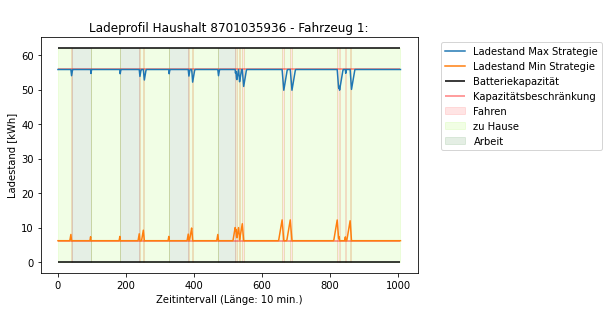





Household: 8511021768
Car: 1
Segment: [1]

Overall energy demand, Household 8511021768 , Car 1 [kWh]: 59.374609416666665

Home energy demand max strategy, Household 8511021768 , Car 1 [kWh]: 45.91723385374997

Work energy demand max strategy, Household 8511021768 , Car 1 [kWh]: 19.543273028125004

Home energy demand min strategy, Household 8511021768 , Car 1 [kWh]: 35.96740320526313

Work energy demand min strategy, Household 8511021768 , Car 1 [kWh]: 26.581540097368414




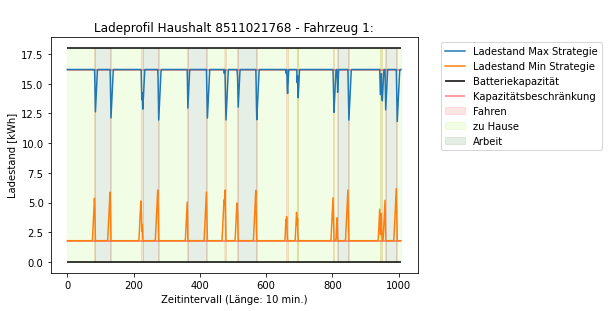





Household: 8511021758
Car: 1
Segment: [11]

Overall energy demand, Household 8511021758 , Car 1 [kWh]: 59.91321826666666

Home energy demand max strategy, Household 8511021758 , Car 1 [kWh]: 27.752467085874997

Work energy demand max strategy, Household 8511021758 , Car 1 [kWh]: 38.30185605312498

Home energy demand min strategy, Household 8511021758 , Car 1 [kWh]: 28.63818438157893

Work energy demand min strategy, Household 8511021758 , Car 1 [kWh]: 35.90427475526314




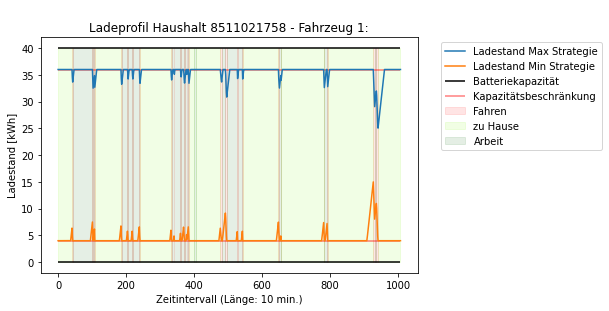





Household: 8511021405
Car: 1
Segment: 3

Overall energy demand, Household 8511021405 , Car 1 [kWh]: 5.2371680000000005

Home energy demand max strategy, Household 8511021405 , Car 1 [kWh]: 5.773977719999997

Work energy demand max strategy, Household 8511021405 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 8511021405 , Car 1 [kWh]: 5.173323842105261

Work energy demand min strategy, Household 8511021405 , Car 1 [kWh]: 0.0




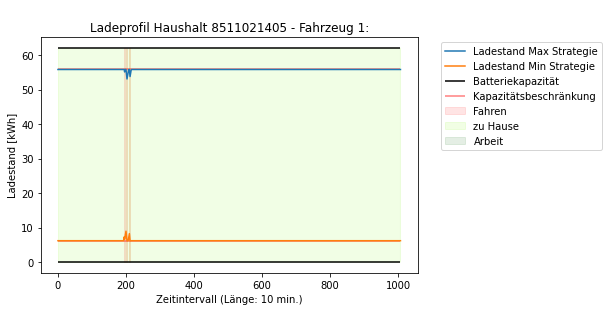





Household: 8501025784
Car: 1
Segment: [2]

Overall energy demand, Household 8501025784 , Car 1 [kWh]: 24.318775500000008

Home energy demand max strategy, Household 8501025784 , Car 1 [kWh]: 26.81144998875002

Work energy demand max strategy, Household 8501025784 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 8501025784 , Car 1 [kWh]: 24.487195618421055

Work energy demand min strategy, Household 8501025784 , Car 1 [kWh]: 0.0




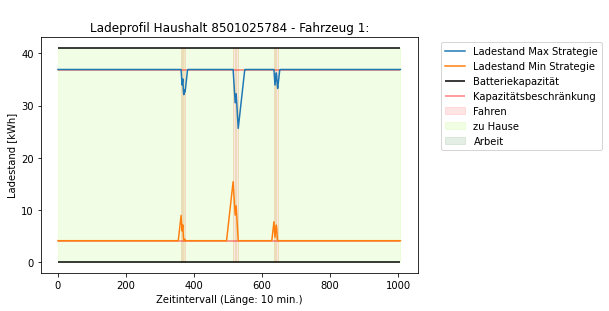





Household: 8311010308
Car: 1
Segment: [3]

Overall energy demand, Household 8311010308 , Car 1 [kWh]: 47.555977066666664

Home energy demand max strategy, Household 8311010308 , Car 1 [kWh]: 38.162485002249966

Work energy demand max strategy, Household 8311010308 , Car 1 [kWh]: 13.033210071000001

Home energy demand min strategy, Household 8311010308 , Car 1 [kWh]: 39.59075654210524

Work energy demand min strategy, Household 8311010308 , Car 1 [kWh]: 12.102213310526322




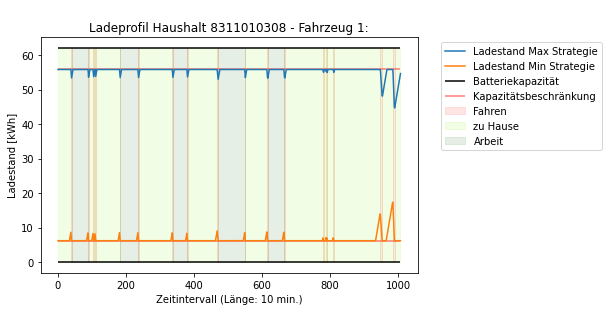





Household: 8301014849
Car: 1
Segment: 3

Overall energy demand, Household 8301014849 , Car 1 [kWh]: 14.261602466666666

Home energy demand max strategy, Household 8301014849 , Car 1 [kWh]: 14.485462099500008

Work energy demand max strategy, Household 8301014849 , Car 1 [kWh]: 1.2379546199999962

Home energy demand min strategy, Household 8301014849 , Car 1 [kWh]: 14.70597704210527

Work energy demand min strategy, Household 8301014849 , Car 1 [kWh]: 1.0568467368421055




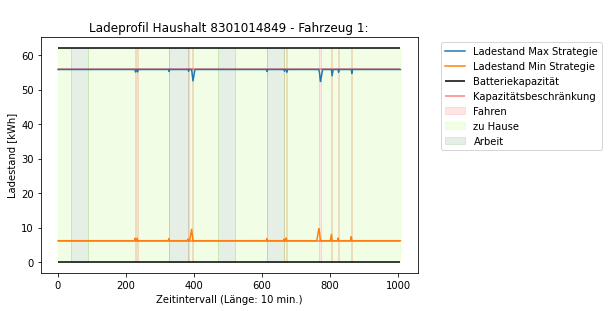





Household: 8301014463
Car: 1
Segment: [3]

Overall energy demand, Household 8301014463 , Car 1 [kWh]: 35.321549333333344

Home energy demand max strategy, Household 8301014463 , Car 1 [kWh]: 22.277403487500006

Work energy demand max strategy, Household 8301014463 , Car 1 [kWh]: 16.664604652500028

Home energy demand min strategy, Household 8301014463 , Car 1 [kWh]: 22.342051052631582

Work energy demand min strategy, Household 8301014463 , Car 1 [kWh]: 15.766763157894745




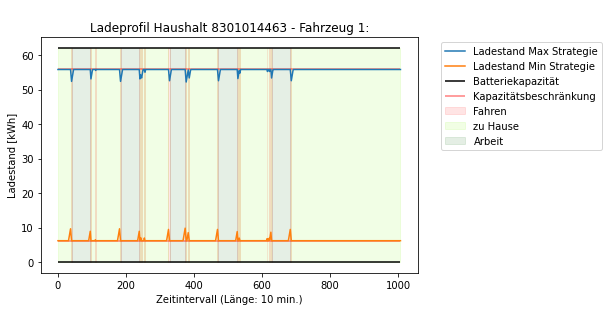





Household: 8301012319
Car: 1
Segment: 3

Overall energy demand, Household 8301012319 , Car 1 [kWh]: 50.50343249999998

Home energy demand max strategy, Household 8301012319 , Car 1 [kWh]: 36.47662269999997

Work energy demand max strategy, Household 8301012319 , Car 1 [kWh]: 19.203411631250003

Home energy demand min strategy, Household 8301012319 , Car 1 [kWh]: 41.80982326315786

Work energy demand min strategy, Household 8301012319 , Car 1 [kWh]: 13.394635026315793




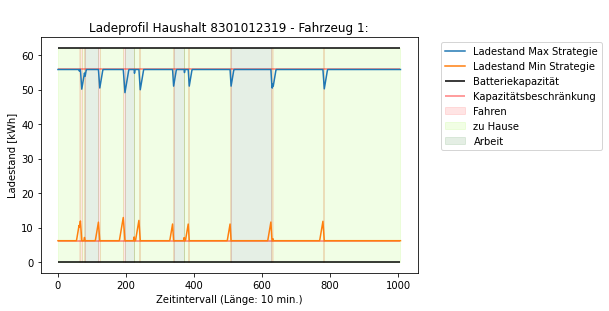





Household: 8301011969
Car: 1
Segment: [3]


Household: 8301011941
Car: 1
Segment: [2]

Overall energy demand, Household 8301011941 , Car 1 [kWh]: 29.970043850000003

Home energy demand max strategy, Household 8301011941 , Car 1 [kWh]: 21.07793203424999

Work energy demand max strategy, Household 8301011941 , Car 1 [kWh]: 11.964041310375007

Home energy demand min strategy, Household 8301011941 , Car 1 [kWh]: 20.198792821052635

Work energy demand min strategy, Household 8301011941 , Car 1 [kWh]: 11.08061748684211




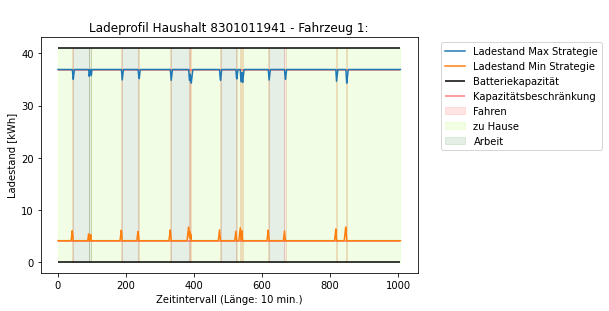





Household: 8301011932
Car: 1
Segment: [3]

Overall energy demand, Household 8301011932 , Car 1 [kWh]: 36.158808400000005

Home energy demand max strategy, Household 8301011932 , Car 1 [kWh]: 31.668494885999973

Work energy demand max strategy, Household 8301011932 , Car 1 [kWh]: 8.196591374999969

Home energy demand min strategy, Household 8301011932 , Car 1 [kWh]: 23.721025999999995

Work energy demand min strategy, Household 8301011932 , Car 1 [kWh]: 14.842193284210538




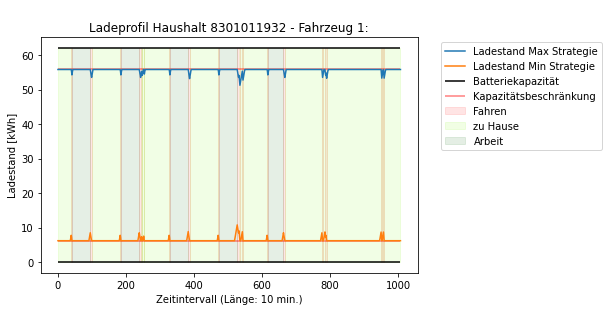





Household: 4711036086
Car: 1
Segment: 3

Overall energy demand, Household 4711036086 , Car 1 [kWh]: 48.463541200000044

Home energy demand max strategy, Household 4711036086 , Car 1 [kWh]: 53.431054172999964

Work energy demand max strategy, Household 4711036086 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 4711036086 , Car 1 [kWh]: 52.949841589473635

Work energy demand min strategy, Household 4711036086 , Car 1 [kWh]: 0.0




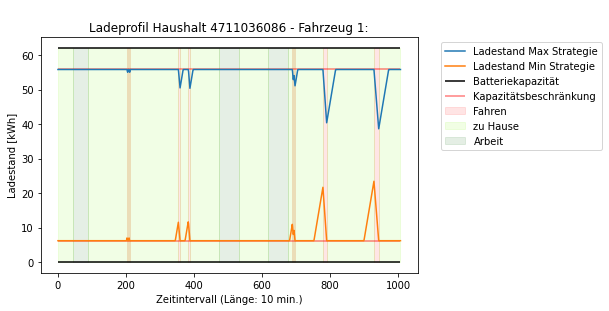





Household: 4711031115
Car: 1
Segment: 3

Overall energy demand, Household 4711031115 , Car 1 [kWh]: 22.958437900000003

Home energy demand max strategy, Household 4711031115 , Car 1 [kWh]: 19.49303157900001

Work energy demand max strategy, Household 4711031115 , Car 1 [kWh]: 5.8186462057500075

Home energy demand min strategy, Household 4711031115 , Car 1 [kWh]: 19.375817668421057

Work energy demand min strategy, Household 4711031115 , Car 1 [kWh]: 4.9818033263157915




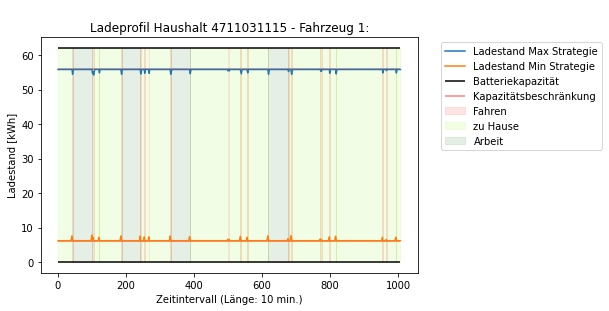





Household: 4711030961
Car: 1
Segment: 3

Overall energy demand, Household 4711030961 , Car 1 [kWh]: 7.1201954

Home energy demand max strategy, Household 4711030961 , Car 1 [kWh]: 3.9043441815000035

Work energy demand max strategy, Household 4711030961 , Car 1 [kWh]: 3.945671247000003

Home energy demand min strategy, Household 4711030961 , Car 1 [kWh]: 3.9555601473684185

Work energy demand min strategy, Household 4711030961 , Car 1 [kWh]: 3.9141295052631584




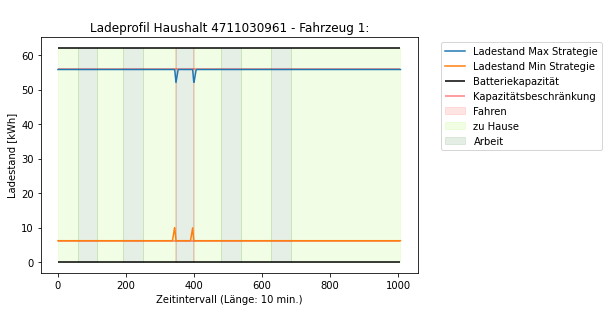





Household: 4711030820
Car: 1
Segment: [3]

Overall energy demand, Household 4711030820 , Car 1 [kWh]: 35.774488666666656

Home energy demand max strategy, Household 4711030820 , Car 1 [kWh]: 37.64245316999999

Work energy demand max strategy, Household 4711030820 , Car 1 [kWh]: 1.7989205849999996

Home energy demand min strategy, Household 4711030820 , Car 1 [kWh]: 39.54022431578944

Work energy demand min strategy, Household 4711030820 , Car 1 [kWh]: 0.0




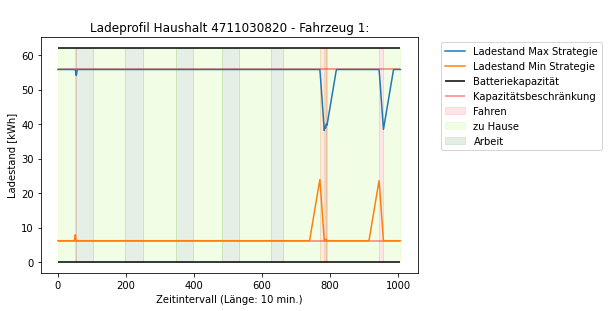





Household: 4711030345
Car: 1
Segment: [1]

Overall energy demand, Household 4711030345 , Car 1 [kWh]: 46.61361175000001

Home energy demand max strategy, Household 4711030345 , Car 1 [kWh]: 37.360615031249985

Work energy demand max strategy, Household 4711030345 , Car 1 [kWh]: 14.03089192312501

Home energy demand min strategy, Household 4711030345 , Car 1 [kWh]: 38.37015377631576

Work energy demand min strategy, Household 4711030345 , Car 1 [kWh]: 13.150153947368425




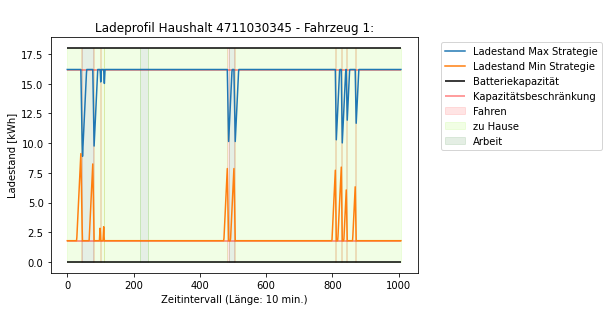





Household: 4711030135
Car: 1
Segment: [2]

Overall energy demand, Household 4711030135 , Car 1 [kWh]: 30.431270166666664

Home energy demand max strategy, Household 4711030135 , Car 1 [kWh]: 24.71677734749999

Work energy demand max strategy, Household 4711030135 , Car 1 [kWh]: 8.833698011250004

Home energy demand min strategy, Household 4711030135 , Car 1 [kWh]: 25.016086973684214

Work energy demand min strategy, Household 4711030135 , Car 1 [kWh]: 8.264253052631581




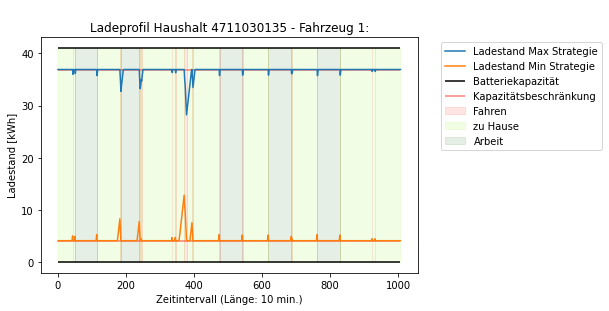





Household: 4701036000
Car: 1
Segment: [3]

Overall energy demand, Household 4701036000 , Car 1 [kWh]: 25.9670653

Home energy demand max strategy, Household 4701036000 , Car 1 [kWh]: 26.594077670999987

Work energy demand max strategy, Household 4701036000 , Car 1 [kWh]: 2.0346118222500067

Home energy demand min strategy, Household 4701036000 , Car 1 [kWh]: 21.02368564210526

Work energy demand min strategy, Household 4701036000 , Car 1 [kWh]: 2.2462748736842095




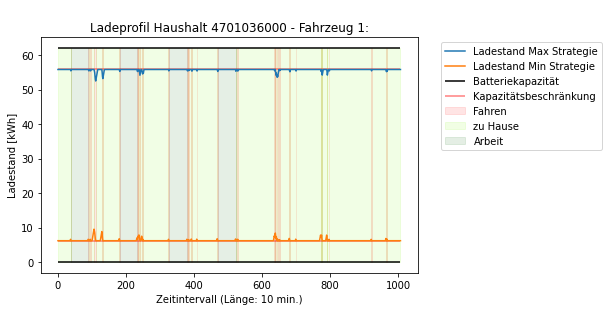





Household: 4701035703
Car: 1
Segment: [3]

Overall energy demand, Household 4701035703 , Car 1 [kWh]: 57.072170766666666

Home energy demand max strategy, Household 4701035703 , Car 1 [kWh]: 30.86535968775

Work energy demand max strategy, Household 4701035703 , Car 1 [kWh]: 32.05670858249999

Home energy demand min strategy, Household 4701035703 , Car 1 [kWh]: 32.447315526315776

Work energy demand min strategy, Household 4701035703 , Car 1 [kWh]: 30.230082584210507




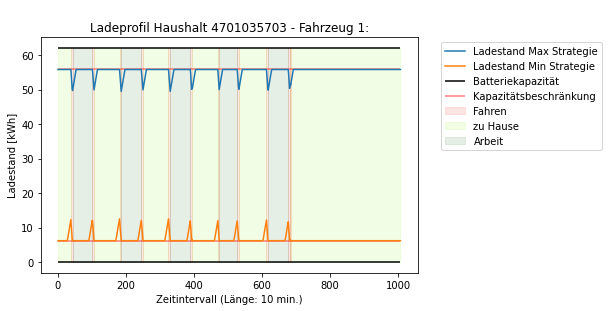





Household: 4701035634
Car: 1
Segment: [13]

Overall energy demand, Household 4701035634 , Car 1 [kWh]: 90.51617911666666

Home energy demand max strategy, Household 4701035634 , Car 1 [kWh]: 59.545251173625715

Work energy demand max strategy, Household 4701035634 , Car 1 [kWh]: 40.24883630250046

Home energy demand min strategy, Household 4701035634 , Car 1 [kWh]: 56.02518489473677

Work energy demand min strategy, Household 4701035634 , Car 1 [kWh]: 42.29629281315786




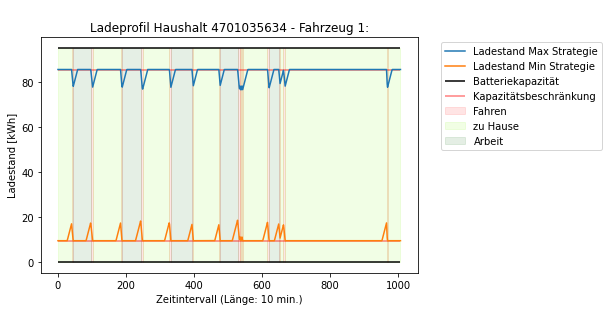





Household: 4701035419
Car: 1
Segment: [2]

Overall energy demand, Household 4701035419 , Car 1 [kWh]: 51.45745628333333

Home energy demand max strategy, Household 4701035419 , Car 1 [kWh]: 43.411580992499985

Work energy demand max strategy, Household 4701035419 , Car 1 [kWh]: 13.320264559875016

Home energy demand min strategy, Household 4701035419 , Car 1 [kWh]: 38.15434178684208

Work energy demand min strategy, Household 4701035419 , Car 1 [kWh]: 15.644063842105272




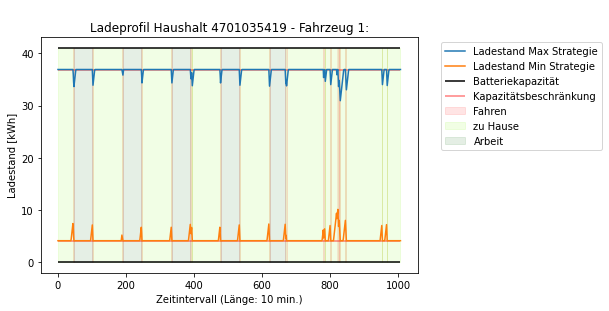





Household: 4701035305
Car: 1
Segment: [2]

Overall energy demand, Household 4701035305 , Car 1 [kWh]: 35.939738000000006

Home energy demand max strategy, Household 4701035305 , Car 1 [kWh]: 28.280325071249997

Work energy demand max strategy, Household 4701035305 , Car 1 [kWh]: 11.343236073749999

Home energy demand min strategy, Household 4701035305 , Car 1 [kWh]: 24.94671328947368

Work energy demand min strategy, Household 4701035305 , Car 1 [kWh]: 13.523936889473692




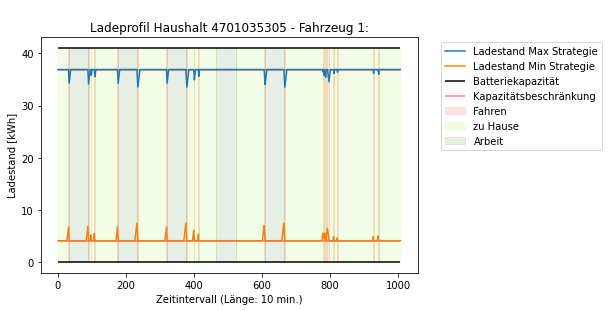





Household: 4701035300
Car: 1
Segment: [3]

Overall energy demand, Household 4701035300 , Car 1 [kWh]: 19.77320916666667

Home energy demand max strategy, Household 4701035300 , Car 1 [kWh]: 21.799963106250022

Work energy demand max strategy, Household 4701035300 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 4701035300 , Car 1 [kWh]: 21.854599605263164

Work energy demand min strategy, Household 4701035300 , Car 1 [kWh]: 0.0




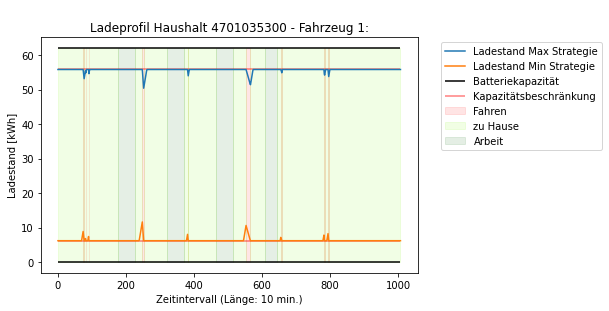





Household: 4701034903
Car: 1
Segment: 3

Overall energy demand, Household 4701034903 , Car 1 [kWh]: 37.70900433333332

Home energy demand max strategy, Household 4701034903 , Car 1 [kWh]: 21.58138017000001

Work energy demand max strategy, Household 4701034903 , Car 1 [kWh]: 19.992797107500017

Home energy demand min strategy, Household 4701034903 , Car 1 [kWh]: 22.330165421052627

Work energy demand min strategy, Household 4701034903 , Car 1 [kWh]: 17.959924500000007




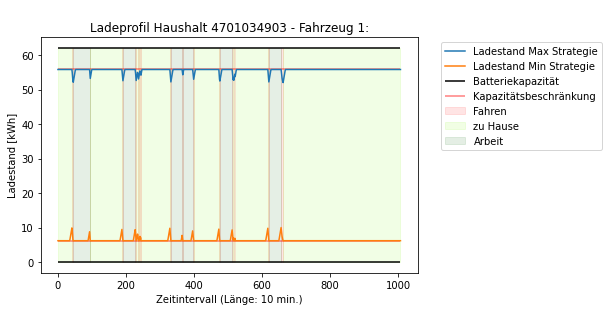





Household: 4701034786
Car: 1
Segment: 3

Overall energy demand, Household 4701034786 , Car 1 [kWh]: 41.79483263333332

Home energy demand max strategy, Household 4701034786 , Car 1 [kWh]: 46.078802978249996

Work energy demand max strategy, Household 4701034786 , Car 1 [kWh]: 0.0

Home energy demand min strategy, Household 4701034786 , Car 1 [kWh]: 46.19428869999997

Work energy demand min strategy, Household 4701034786 , Car 1 [kWh]: 0.0




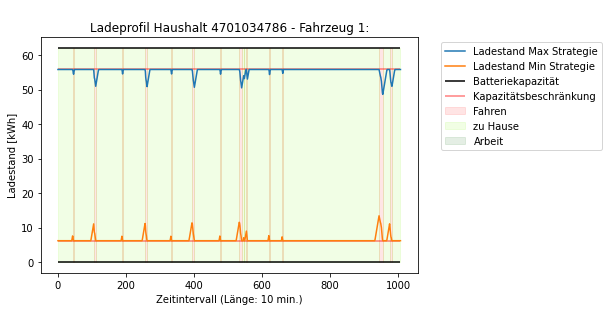

In [8]:
### Create SOC profiles for each car from every household

'''
Choose the following parameters:
- household_list:           put "households" for whole list from rank_households
- start, end:               first and last timestep
- home_charging_power:      possible charging power at home [kW]
- work_charging_power:      -"- at work -> only one of both can be 0 [kW]
- charging_efficiency:      efficiency while charging
- discharging_efficiency:   efficiency while discharging (= consuming)
- min_charge:               SOC can not go lower (relative to battery capacity)
- max_charge:               SOC can not go higher (relative to battery capacity)
- path:                     path where csv-outputs should be saved
- bool_plot:                true, if plots should be created
- bool_create_csv:          true, if csv-files should be created
'''

household_list = households
start = 0
end = 1008
home_charging_power = 3.7
work_charging_power = 3.7
charging_efficiency = 0.95
discharging_efficiency = 0.95
min_SOC = 0.1
max_SOC = 0.9
bool_plot = True
bool_create_csv = False
path_csv = path_directory + '/outputs/'

###

create_soc_profiles(household_list,
                meta_mop_data,
                states_mop_data,
                speed_mop_data,
                start,
                end,
                no_of_ts,
                ts_length,
                home_charging_power,
                work_charging_power,
                charging_efficiency,
                discharging_efficiency,
                min_SOC,
                max_SOC,
                weather_csv,
                mob_car_info_csv,
                el_cars_csv,
                path_csv,
                bool_plot,
                bool_create_csv)

### Aggregated Load Profiles: PLOT 1 (24h)

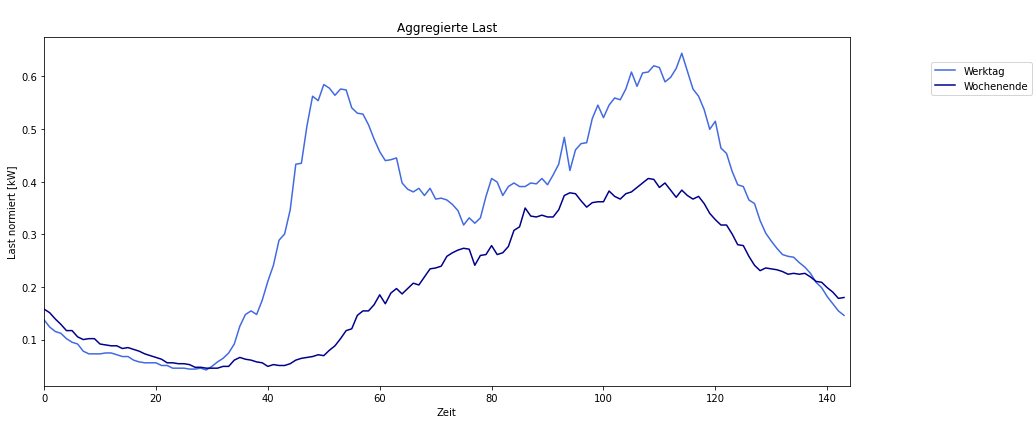

In [9]:
# PLOT 1: Aggregated Profile for one day (Weekday and Weekend)

household_list = all_households
start_weekday = 0
end_weekday = 1008
start_weekend = 0
end_weekend = 1008
home_charging_power = 3.7
work_charging_power = 3.7
charging_efficiency = 0.95
discharging_efficiency = 0.95
min_SOC = 0.1
max_SOC = 0.9
bool_winter = False
bool_plot = True

###
weekday = aggregated_profiles_day(household_list,
                meta_mop_data,
                states_mop_data,
                speed_mop_data,
                start_weekday,
                end_weekday,
                no_of_ts,
                ts_length,
                home_charging_power,
                work_charging_power,
                charging_efficiency,
                discharging_efficiency,
                min_SOC,
                max_SOC,
                weather_csv,
                mob_car_info_csv,
                el_cars_csv,
                bool_winter,
                bool_plot)

weekend = aggregated_profiles_day(household_list,
                meta_mop_data,
                states_mop_data,
                speed_mop_data,
                start_weekend,
                end_weekend,
                no_of_ts,
                ts_length,
                home_charging_power,
                work_charging_power,
                charging_efficiency,
                discharging_efficiency,
                min_SOC,
                max_SOC,
                weather_csv,
                mob_car_info_csv,
                el_cars_csv,
                bool_winter,
                bool_plot)


fig, ax = plt.subplots(figsize=(12,6))
figure_title = ("\nAggregierte Last")

ax.plot(weekday [432:576], color = "royalblue", label = "Werktag")
ax.plot(weekend [864:1008], color = "darkblue", label = "Wochenende")

ax.set_xlabel("Zeit")
ax.set_ylabel("Last normiert [kW]")
 
#ax.set_xticks(np.arange(min(ax.get_xticks()),max(ax.get_xticks()),36));
#labels = ['00:00 Uhr', '06:00 Uhr', '12:00 Uhr', '18:00 Uhr' , '00:00 Uhr']
#ax.set_xticklabels(labels, rotation = 0)

ax.set_xlim(0,144)
fig.legend(bbox_to_anchor = (1.2,0.85), loc="upper right")
ax.set_title(figure_title)
plt.tight_layout()
#plt.savefig("...", bbox_inches='tight')
plt.show()

### Aggregated Load Profiles: PLOT 2 (7 days)

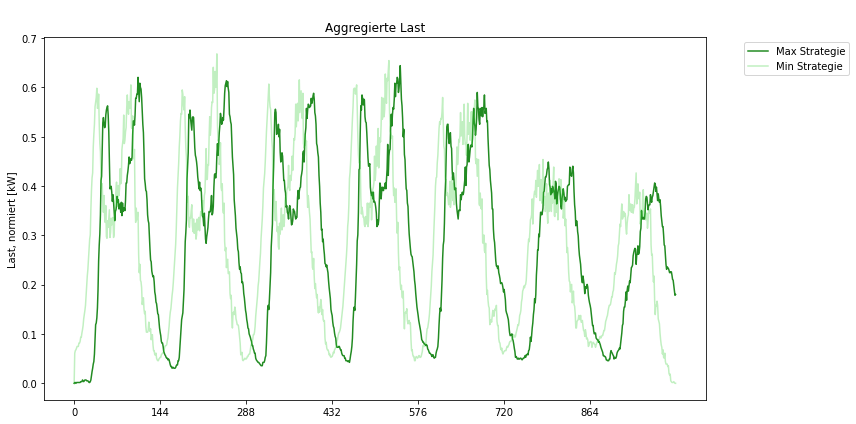

In [10]:
# PLOT 2: Aggregated Profile for one week

household_list = all_households
start = 0
end = 1008
home_charging_power = 3.7
work_charging_power = 3.7
charging_efficiency = 0.95
discharging_efficiency = 0.95
min_SOC = 0.1
max_SOC = 0.9
bool_winter = False
bool_plot = True

###
aggregated_profiles_week(household_list,
                meta_mop_data,
                states_mop_data,
                speed_mop_data,
                start,
                end,
                no_of_ts,
                ts_length,
                home_charging_power,
                work_charging_power,
                charging_efficiency,
                discharging_efficiency,
                min_SOC,
                max_SOC,
                weather_csv,
                mob_car_info_csv,
                el_cars_csv,
                bool_winter,
                bool_plot)

### Aggregated Profiles: PLOT 3 (Lastprofil Ladestrategien)

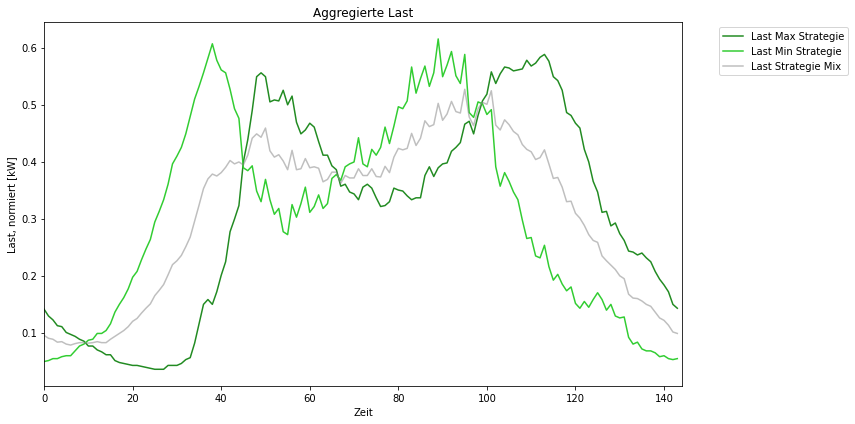

In [11]:
# PLOT 3: Aggregated Profile for Max and Min Strategy

household_list = all_households
start = 0
end = 1008
home_charging_power = 3.7
work_charging_power = 3.7
charging_efficiency = 0.95
discharging_efficiency = 0.95
min_SOC = 0.1
max_SOC = 0.9
bool_winter = False
bool_plot = True

###

aggregated_profiles_strategies(household_list,
                meta_mop_data,
                states_mop_data,
                speed_mop_data,
                start,
                end,
                no_of_ts,
                ts_length,
                home_charging_power,
                work_charging_power,
                charging_efficiency,
                discharging_efficiency,
                min_SOC,
                max_SOC,
                weather_csv,
                mob_car_info_csv,
                el_cars_csv,
                bool_winter,
                bool_plot)

### Aggregated Profiles: PLOT 4 (Lastprofil Winter Sommer)

Summer: 291.1493798805705
Winter: 365.30234267340603


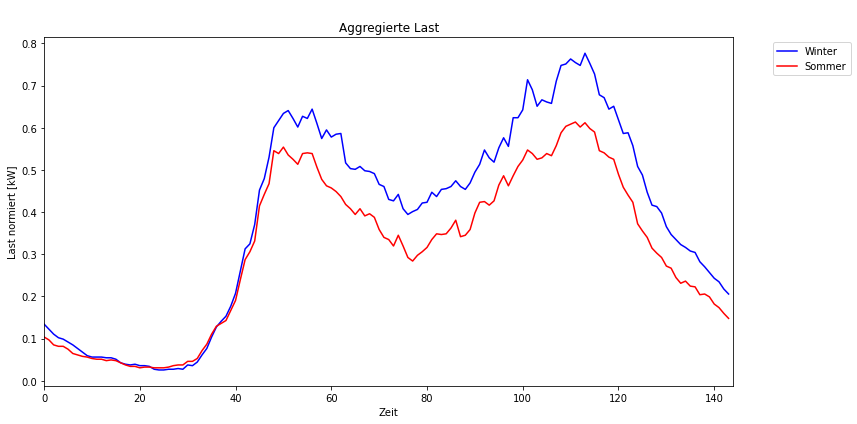

In [12]:
household_list = all_households
start = 0
end = 1008
home_charging_power = 3.7
work_charging_power = 3.7
charging_efficiency = 0.95
discharging_efficiency = 0.95
min_SOC = 0.1
max_SOC = 0.9
bool_winter = False
bool_plot = True
bool_create_csv = False
path_csv = path_directory + '/outputs/'

###

summer = aggregated_profiles_day(household_list,
                meta_mop_data,
                states_mop_data,
                speed_mop_data,
                start,
                end,
                no_of_ts,
                ts_length,
                home_charging_power,
                work_charging_power,
                charging_efficiency,
                discharging_efficiency,
                min_SOC,
                max_SOC,
                weather_csv,
                mob_car_info_csv,
                el_cars_csv,
                bool_winter,
                bool_plot)

bool_winter = True
winter = aggregated_profiles_day(household_list,
                meta_mop_data,
                states_mop_data,
                speed_mop_data,
                start,
                end,
                no_of_ts,
                ts_length,
                home_charging_power,
                work_charging_power,
                charging_efficiency,
                discharging_efficiency,
                min_SOC,
                max_SOC,
                weather_csv,
                mob_car_info_csv,
                el_cars_csv,
                bool_winter,
                bool_plot)

fig, ax = plt.subplots(figsize=(12,6))
figure_title = ("\nAggregierte Last")
ax.plot(winter[144:288], color = "blue", label = "Winter")
ax.plot(summer[144:288], color = "red", label = "Sommer")

print("Summer:", sum(summer))
print("Winter:", sum(winter))

ax.set_xlim(0,144)
ax.set_xlabel("Zeit")
ax.set_ylabel("Last normiert [kW]")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
ax.set_title(figure_title)
#ax.set_xticks(np.arange(min(ax.get_xticks()),max(ax.get_xticks()),36));
#labels = ['00:00 Uhr', '06:00 Uhr', '12:00 Uhr', '18:00 Uhr' , '00:00 Uhr']
#ax.set_xticklabels(labels, rotation = 0)

plt.tight_layout()
#plt.savefig("...", bbox_inches='tight')
plt.show()

### Aggregated Profiles: PLOT 5 (Lastverschiebepotenzial)

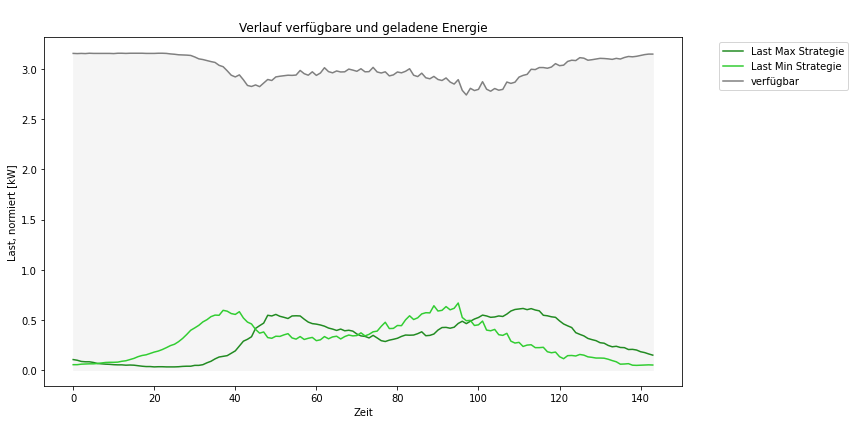

In [13]:
# PLOT 5: LVP

### Create aggregated load profiles for all cars and all households

household_list = all_households
start_weekday = 0
end_weekday = 1008
start_weekend = 720
end_weekend = 888
home_charging_power = 3.7
work_charging_power = 3.7
charging_efficiency = 0.95
discharging_efficiency = 0.95
min_SOC = 0.1
max_SOC = 0.9
bool_winter = False
bool_plot = True

###
aggregated_profiles_lvp(household_list,
                meta_mop_data,
                states_mop_data,
                speed_mop_data,
                start_weekday,
                end_weekday,
                no_of_ts,
                ts_length,
                home_charging_power,
                work_charging_power,
                charging_efficiency,
                discharging_efficiency,
                min_SOC,
                max_SOC,
                weather_csv,
                mob_car_info_csv,
                el_cars_csv,
                bool_winter,
                bool_plot)

### Aggregated Profiles: PLOT 6 (Aggregated Profiles Home / Work)


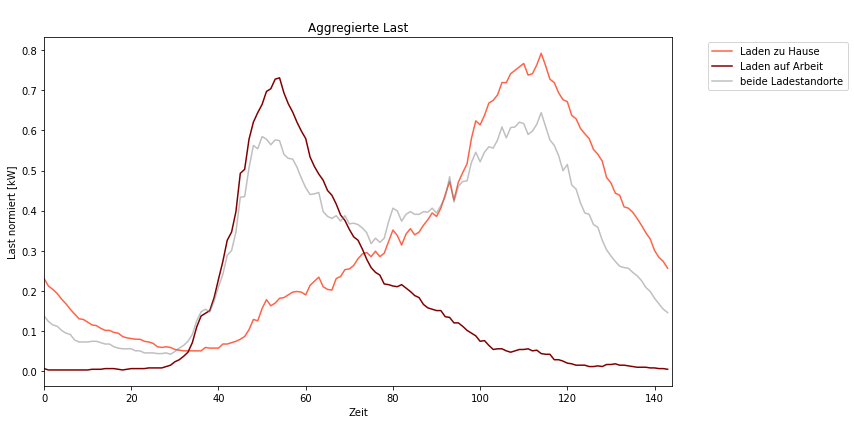

In [14]:
household_list = all_households
start_weekday = 0
end_weekday = 1008

home_charging_power_1 = 3.7
work_charging_power_1 = 0
home_charging_power_2 = 0
work_charging_power_2 = 3.7
home_charging_power_3 = 3.7
work_charging_power_3 = 3.7
charging_efficiency = 0.95
discharging_efficiency = 0.95
min_SOC = 0.1
max_SOC = 0.9
bool_winter = False
bool_plot = True

###
home_profile = aggregated_profiles_day(household_list,
                meta_mop_data,
                states_mop_data,
                speed_mop_data,
                start_weekday,
                end_weekday,
                no_of_ts,
                ts_length,
                home_charging_power_1,
                work_charging_power_1,
                charging_efficiency,
                discharging_efficiency,
                min_SOC,
                max_SOC,
                weather_csv,
                mob_car_info_csv,
                el_cars_csv,
                bool_winter,
                bool_plot)

work_profile = aggregated_profiles_day(household_list,
                meta_mop_data,
                states_mop_data,
                speed_mop_data,
                start_weekday,
                end_weekday,
                no_of_ts,
                ts_length,
                home_charging_power_2,
                work_charging_power_2,
                charging_efficiency,
                discharging_efficiency,
                min_SOC,
                max_SOC,
                weather_csv,
                mob_car_info_csv,
                el_cars_csv,
                bool_winter,
                bool_plot)

agg = aggregated_profiles_day(household_list,
                meta_mop_data,
                states_mop_data,
                speed_mop_data,
                start_weekday,
                end_weekday,
                no_of_ts,
                ts_length,
                home_charging_power_3,
                work_charging_power_3,
                charging_efficiency,
                discharging_efficiency,
                min_SOC,
                max_SOC,
                weather_csv,
                mob_car_info_csv,
                el_cars_csv,
                bool_winter,
                bool_plot)

fig, ax = plt.subplots(figsize=(12,6))
figure_title = ("\nAggregierte Last")

ax.plot(home_profile [432:576], color = "tomato", label = "Laden zu Hause")
ax.plot(work_profile [432:576], color = "maroon", label = "Laden auf Arbeit")
ax.plot(agg [432:576], color = "grey", label = "beide Ladestandorte", alpha =0.5)
ax.set_xlim(0,144)
ax.set_xlabel("Zeit")
ax.set_ylabel("Last normiert [kW]")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
ax.set_title(figure_title)
#ax.set_xticks(np.arange(min(ax.get_xticks()),max(ax.get_xticks()),36));
#labels = ['00:00 Uhr', '06:00 Uhr', '12:00 Uhr', '18:00 Uhr' , '00:00 Uhr']
#ax.set_xticklabels(labels, rotation = 0)
plt.tight_layout()
#plt.savefig("...", bbox_inches='tight')
plt.show()